 1. Маппинг unified_id
 2. Загрузка датасетов из открытых источников
 3. Попытка сметчить каталог и открытые данные
 4. Отбор айдишников из каталога, которые имеются в candidates
 5. Создание аналогичного датасета, но на основе Кинопоиска

In [3]:
import msgpack
import boto3
import awswrangler as wr
from io import BytesIO
import pickle
import numpy as np
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import json

np.random.seed(1)

In [4]:
import matplotlib
matplotlib.__version__

'3.6.2'

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Connection

In [6]:
ACCESS_KEY='du3wAsX0uzEBBn4AdkFpCX4ZTXvSWFVG48GA4jbT'
SECRET_KEY='WA0NJOX0AFAY4K1J92XZ'

wr.config.s3_endpoint_url = 'https://obs.ru-moscow-1.hc.sbercloud.ru'

boto3.setup_default_session(
    region_name='ru-moscow',
    aws_access_key_id=SECRET_KEY,
    aws_secret_access_key=ACCESS_KEY,
)

def _get_default_boto3_client():
    return boto3.client('s3', endpoint_url=wr.config.s3_endpoint_url)

def get_object(s3_url):
    s3_client = _get_default_boto3_client()
    bucket, key = _split_3s_url_to_bucket_and_key(s3_url)
    return s3_client.get_object(Bucket=bucket, Key=key)




In [7]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
from datetime import date
from scipy import sparse

spark = SparkSession.builder.appName("Dummy").master('local').config(
    "spark.driver.memory", "100g"
).config(
    "spark.driver.cores", '16'
).config(
    "spark.kryoserializer.buffer.max", '2047'
).getOrCreate()
print("session = ", spark.getActiveSession())
config_spark_s3_adv = {
    'access_id': 'WA0NJOX0AFAY4K1J92XZ',
    'access_key': 'du3wAsX0uzEBBn4AdkFpCX4ZTXvSWFVG48GA4jbT',
    'impl': 'org.apache.hadoop.fs.s3a.S3AFileSystem',
    'endpoint': 'https://obs.ru-moscow-1.hc.sbercloud.ru'
}

spark._jsc.hadoopConfiguration().set("fs.s3a.impl", config_spark_s3_adv["impl"])
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", config_spark_s3_adv["endpoint"])
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", config_spark_s3_adv["access_id"])
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", config_spark_s3_adv["access_key"])
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")
spark.sparkContext.uiWebUrl

22/11/21 10:53:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/21 10:53:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


session =  <pyspark.sql.session.SparkSession object at 0x7f1ff306b520>


'http://259bc79ca0eb:4041'

# Data Loading

In [8]:
def get_elements_dict(catalogue: pd.DataFrame):
    """
    Gets the result of reading json catalogue in form of pd.DataFrame.
    Returns dictionary of elements
    """
    elements = catalogue[~catalogue['elements'].isnull()]
    elements_dict = {}
    for el_id, el_features in zip(elements.index, elements['elements']):
        elements_dict[el_id] = el_features
    return elements_dict

def get_unique_features(elements_dict):
    """
    Returns all unique features that an element might have. 
    """
    unique_features = []
    for film, fields in elements_dict.items():
        unique_features.extend(list(fields.keys()))

    return set(unique_features)

In [9]:
path_catalogue = 's3://okko-prod/okko/datasets/catalogue/catalogue_00001_20221004215746.json'
catalogue = wr.s3.read_json(path_catalogue)

In [10]:
catalogue

,elements,groups
42c5cbc6-7a44-4f7b-a620-d86f43290d1d,{'uid': '42c5cbc6-7a44-4f7b-a620-d86f43290d1d'...,NaN
04579553-398a-4aa9-a672-e841ed4a6380,{'uid': '04579553-398a-4aa9-a672-e841ed4a6380'...,NaN
e785baa6-f175-42b4-9e16-4319ac7991d5,{'uid': 'e785baa6-f175-42b4-9e16-4319ac7991d5'...,NaN
f3921ca6-7441-46cc-a83a-c6beee368bf0,{'uid': 'f3921ca6-7441-46cc-a83a-c6beee368bf0'...,NaN
5197752b-c863-4858-a12e-76d65c0a93e5,{'uid': '5197752b-c863-4858-a12e-76d65c0a93e5'...,NaN
...,...,...
3aed300f-8d62-48f5-aa31-754a91c62f97,NaN,{'uid': '3aed300f-8d62-48f5-aa31-754a91c62f97'...
a10740e8-177f-4771-ae16-309dc55170c2,NaN,{'uid': 'a10740e8-177f-4771-ae16-309dc55170c2'...
027c5e28-972a-4a06-a028-28ff88dae096,NaN,{'uid': '027c5e28-972a-4a06-a028-28ff88dae096'...
f6cab608-9a61-414e-9042-a0c23846a6ff,NaN,{'uid': 'f6cab608-9a61-414e-9042-a0c23846a6ff'...


In [32]:
group_names = np.array([g.get('name', '').lower() for g in catalogue['groups'].dropna()])

In [35]:
[n for n in group_names if 'orig' in n]

['okko originals', 'сериалы okko originals', 'okko originals']

In [39]:
orig_ids = np.array([g['children'] for g in catalogue['groups'].dropna() if g.get('name', '').lower() in ['okko originals', 'сериалы okko originals', 'okko originals']])

In [43]:
all_orig_ids = []

for orig_list in orig_ids:
    all_orig_ids.extend(orig_list)

In [50]:
set(all_orig_ids)

{'005548f7-2402-4489-aaa4-ccbd60c47485',
 '00b0b9fc-28a2-481e-8057-8197cab377a8',
 '01a06c58-b45f-41e8-a9a1-93de79c7ae2f',
 '01c14d2e-649b-48c8-be2a-ccfc5d5e4b0f',
 '03d5826c-d92b-49de-a563-3960538ba299',
 '07cf3ed4-21c6-4a3d-9e23-9811ad6fef69',
 '0969df0f-c83a-413b-8894-e45e7e0caa20',
 '0b480a03-01b6-4f3e-b4ca-8eb91e2f4009',
 '177e4535-2499-44dd-86ba-bd6fd69004dc',
 '3129c081-3f65-433b-a328-8bceeed91187',
 '337f4449-9141-4cff-93fa-f88a7c691906',
 '351d5ab7-59ae-48bf-931e-5749c35923f7',
 '36d9d568-75d0-414d-9765-25bf72c6362f',
 '3cfb5023-3c07-4384-8acf-d488d5a0ffa4',
 '3e73d0b9-3dff-45a6-96ee-5e4105f8d041',
 '3feaf0f5-6ce5-4e02-ac5a-db84afaa5328',
 '40fa07f4-23f5-464d-9b0f-ae9595496155',
 '49a3d528-44c0-408e-b6fc-a1507ce7641a',
 '49d80996-f42b-4ddf-b181-d5c7a9eaacbb',
 '4a69f5d3-e4e5-4122-b22e-9e2bb4f4e54e',
 '52dfe214-0989-4de7-ab08-3ee93286626d',
 '54c7fbf9-dff4-425d-8164-9a0b1da7d850',
 '55d7867c-6e78-4d08-8722-00cc8c4353d0',
 '562c5b6c-ed2a-4995-aeb8-49167ab715b6',
 '57f62b6e-c199-

In [11]:
elements_dict = get_elements_dict(catalogue)
unique_features = get_unique_features(elements_dict)

In [12]:
unique_features

{'actor',
 'age_access_type',
 'age_restriction_aliases',
 'alias',
 'availability',
 'average_rating',
 'box_office_russia',
 'box_office_worldwide',
 'budget',
 'children',
 'country',
 'digital_uid',
 'director',
 'duration',
 'genre',
 'name',
 'release_type',
 'release_year',
 'sale_start_date',
 'subscription_only',
 'type',
 'uid'}

In [13]:
elements_names = {v['name']: v for v in elements_dict.values()}

In [14]:
names = list(elements_names.keys())

In [15]:
names[0]

'Энни Лейбовиц: Жизнь, увиденная через объектив'

# Mapping

In [18]:
path_mapping = 's3://okko-prod/pipelines/etl-catalogue-transform_0.1/202209180400/outgoing/element_mapping.par'
# pipelines/etl-catalogue-transform_0.1/202209180400/outgoing/element_mapping.par
mapping = wr.s3.read_parquet(path_mapping)

In [19]:
mapping

,element_uid,unified_element_uid
0,e55c8ada-769c-4847-9646-3136eb90b1a8,2f810936-d747-4477-89cc-d5fa3ed4b71d
1,6150dada-0f0a-4ad9-82e4-fb6bd2ed324a,2f810936-d747-4477-89cc-d5fa3ed4b71d
2,17ea67be-8d67-4419-b32f-2bdfb787b393,2f810936-d747-4477-89cc-d5fa3ed4b71d
3,8ff747bf-d326-4b47-9d7a-b70a7d7f072e,2f810936-d747-4477-89cc-d5fa3ed4b71d
4,0b5701fc-30de-4920-9bbb-de876e714e4a,2f810936-d747-4477-89cc-d5fa3ed4b71d
...,...,...
146113,3b6c7799-0a9e-4ed1-83e3-ada02c400762,ced65093-3d2d-47c3-8567-f8b07b4a97e9
146114,14f0d8d8-07db-468c-894b-58794621c67b,bcfc9ac9-298c-4d12-8333-5024953dd805
146115,56a004e7-efdc-4dc8-a37b-33e89d3a2eb4,ddf1abdf-3f5a-4c52-af72-23bc9ecd196f
146116,c8b90cbd-8154-49ba-886b-83c1a2dde402,c5dd7543-7699-4c11-aa04-def94269fac7


In [20]:
mapping.columns

Index(['element_uid', 'unified_element_uid'], dtype='object')

In [15]:
# mapping Dataframe to mapping dict
mapping_dict = {el_uid: unified_id for el_uid, unified_id in zip(mapping['element_uid'], mapping['unified_element_uid'])}

In [16]:
example_key = mapping['element_uid'][0]
example_key

'e55c8ada-769c-4847-9646-3136eb90b1a8'

In [17]:
elements_dict[example_key]

{'uid': 'e55c8ada-769c-4847-9646-3136eb90b1a8',
 'digital_uid': 601734,
 'type': 'SEASON',
 'alias': 'xena-warrior-princess-s02',
 'name': 'Зена – королева воинов. Сезон 2',
 'release_type': 'RELEASE',
 'availability': ['DTO'],
 'subscription_only': False,
 'children': ['005d75da-2e68-4e85-adf2-7783ee65b671',
  '4776902e-30f5-4112-90af-ccb03eb58c35',
  '5dc2fce0-383e-44c7-80d6-40af6f7fcc90',
  '1a1258a9-2c26-4446-abc3-efb92ad05b4f',
  '527c356a-1f3c-4577-ae87-dd448f9df631',
  '2e695adc-b020-4c79-b690-652b2d45e62e',
  '3f31b7f2-d33c-4c4b-a400-4ac591d0fd0c',
  '67f1df03-379a-45f7-8671-06f02202235d',
  'bdc79648-4ca7-4616-bf99-da60f20530ef',
  '80b844d0-2d3f-49d9-a24c-a964d444644b',
  '8433e76e-1687-4e8b-b3a1-a5d8e2a869e2',
  '58dce713-d301-425b-8b1d-3892fa4a4451',
  'e55f371e-e423-4971-8fa3-23e86d17295e',
  'd3055d73-245a-4264-834d-527840806ee3',
  '1c8f321e-c16b-4a67-80a5-8e46621264c7',
  '3226fbc5-b430-4ec9-b854-7717a853216d',
  'fe15d886-3782-437a-a519-02f00d21d45d',
  'c19d4bd1-8bdf-

In [18]:
# add unified_uids to elements_dict
for element_id, element_features in elements_dict.items():
    if element_id in mapping_dict:
        print(element_features['name'])
        elements_dict[element_id]['unified_id'] = mapping_dict[element_id]
    else:
        elements_dict[element_id]['unified_id'] = element_id

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Детские песенки Little Baby Bum. Сезон 1. Серия 135
Детские песенки Little Baby Bum. Сезон 1. Серия 136
Детские песенки Little Baby Bum. Сезон 1. Серия 137
Детские песенки Little Baby Bum. Сезон 1. Серия 138
Детские песенки Little Baby Bum. Сезон 1. Серия 139
Детские песенки Little Baby Bum. Сезон 1. Серия 140
Детские песенки Little Baby Bum. Сезон 1. Серия 141
Детские песенки Little Baby Bum. Сезон 1. Серия 142
Детские песенки Little Baby Bum. Сезон 1. Серия 143
Детские песенки Little Baby Bum. Сезон 1. Серия 144
Детские песенки Little Baby Bum. Сезон 1. Серия 145
Детские песенки Little Baby Bum. Сезон 1. Серия 146
Детские песенки Little Baby Bum. Сезон 1. Серия 147
Детские песенки Little Baby Bum. Сезон 1. Серия 148
Детские песенки Little Baby Bum. Сезон 1. Серия 149
Детские песенки Little Baby Bum. Сезон 1. Серия 150
Детские песенки Little Baby Bum. Сезон 1. Серия 151
Детские песенки Little Baby Bum. Сезон 1. Серия 152
Детские песенки Little Baby Bum. Сезон 1. Серия 153
Детские песе

In [19]:
len(elements_dict)

184899

In [20]:
# join items belonging to one unified_uid
unified_items = {}

for element in elements_dict.values():
    if 'unified_id' in element:
        unified_items[element['unified_id']] = unified_items.get(element['unified_id'], [])
        unified_items[element['unified_id']].append(element)
    else:
        unified_items[element['uid']] = [element]

In [21]:
# number of unique items in catalogue
len(unified_items)

38825

In [22]:
# example
unified_items['1ff9b60d-ffe3-4eb7-bd7a-eb697255b4fa']

[{'uid': '1ff9b60d-ffe3-4eb7-bd7a-eb697255b4fa',
  'digital_uid': 2874,
  'type': 'MOVIE',
  'alias': 'star-trek',
  'name': 'Звездный путь',
  'release_type': 'RELEASE',
  'availability': ['DTO', 'RENT', 'SUBSCRIPTION'],
  'subscription_only': False,
  'duration': 7620000,
  'release_year': 2009,
  'age_access_type': 16,
  'age_restriction_aliases': [],
  'sale_start_date': 1277323200000,
  'average_rating': 7.75,
  'genre': ['Sci-Fi', 'Action', 'Thriller', 'Adventure'],
  'actor': ['21c7a451-d42c-4c4b-90ee-7bc9658f9361',
   'dd3fe56f-08a3-4922-8540-332ba379eaba',
   '01b40bd1-3c44-49df-a80c-9863c8309e0c',
   'dcc25fcb-b1af-467d-ba94-c0fa1890dfd2',
   '92469aa0-715d-401e-81e9-054b1987df78'],
  'director': ['5a7ba90d-25b5-40ed-aa38-c923850c254c'],
  'country': ['germany', 'usa'],
  'budget': 150000000,
  'unified_id': '1ff9b60d-ffe3-4eb7-bd7a-eb697255b4fa'},
 {'uid': 'bca197d2-df7d-4751-a1a7-1aac817abd25',
  'digital_uid': 749379,
  'type': 'MOVIE',
  'alias': 'star-trek-ultra-hd-4k',


In [23]:
# keep head elements only; element_uid = unified_uid
head_elements_dict = {}

for uni_uid, elements in unified_items.items():
    for element in elements:
        if element['uid'] not in mapping['element_uid']:
            head_elements_dict[uni_uid] = element
            break

In [24]:
head_elements_dict['1ff9b60d-ffe3-4eb7-bd7a-eb697255b4fa']

{'uid': '1ff9b60d-ffe3-4eb7-bd7a-eb697255b4fa',
 'digital_uid': 2874,
 'type': 'MOVIE',
 'alias': 'star-trek',
 'name': 'Звездный путь',
 'release_type': 'RELEASE',
 'availability': ['DTO', 'RENT', 'SUBSCRIPTION'],
 'subscription_only': False,
 'duration': 7620000,
 'release_year': 2009,
 'age_access_type': 16,
 'age_restriction_aliases': [],
 'sale_start_date': 1277323200000,
 'average_rating': 7.75,
 'genre': ['Sci-Fi', 'Action', 'Thriller', 'Adventure'],
 'actor': ['21c7a451-d42c-4c4b-90ee-7bc9658f9361',
  'dd3fe56f-08a3-4922-8540-332ba379eaba',
  '01b40bd1-3c44-49df-a80c-9863c8309e0c',
  'dcc25fcb-b1af-467d-ba94-c0fa1890dfd2',
  '92469aa0-715d-401e-81e9-054b1987df78'],
 'director': ['5a7ba90d-25b5-40ed-aa38-c923850c254c'],
 'country': ['germany', 'usa'],
 'budget': 150000000,
 'unified_id': '1ff9b60d-ffe3-4eb7-bd7a-eb697255b4fa'}

In [25]:
head_elements_dict['42c5cbc6-7a44-4f7b-a620-d86f43290d1d']

{'uid': '42c5cbc6-7a44-4f7b-a620-d86f43290d1d',
 'digital_uid': 14059,
 'type': 'MOVIE',
 'alias': 'annie-leibovitz-life-through-a-lens',
 'name': 'Энни Лейбовиц: Жизнь, увиденная через объектив',
 'release_type': 'RELEASE',
 'availability': [],
 'subscription_only': False,
 'duration': 4800000,
 'release_year': 2006,
 'age_access_type': 12,
 'age_restriction_aliases': [],
 'sale_start_date': 1301947200000,
 'average_rating': 6.0,
 'genre': ['Documentary', '5c403894-146a-47a4-ae75-9f1956a30dbb'],
 'actor': ['6cf76651-d5e4-46db-8384-0993d3431992',
  '3de5e2cf-9865-41c2-a233-963b216f760a',
  '8c09cc22-779b-4ed5-8d97-7ec10e2907fd'],
 'director': ['4551ef07-32ff-43aa-92dc-35fd175479df'],
 'country': ['usa'],
 'unified_id': '42c5cbc6-7a44-4f7b-a620-d86f43290d1d'}

In [26]:
# create dataframe; index = unified_uid
from tqdm import tqdm
items_df = pd.DataFrame(np.full(
                                (len(head_elements_dict), 
                                 len(unique_features)),
                                np.nan
                               ),
                        columns=list(unique_features),
                        index=list(head_elements_dict.keys()),
                        dtype='object'
                       )

for uid, features  in tqdm(head_elements_dict.items()):
    for feature_name, feature_value in  features.items():
        if feature_value == []:
            continue
        items_df.at[uid, feature_name] = feature_value

100% 38825/38825 [05:10<00:00, 124.96it/s]


In [29]:
items_df.shape

(38825, 23)

In [30]:
items_df.head()

,budget,release_year,box_office_russia,country,type,duration,uid,average_rating,children,sale_start_date,...,alias,director,digital_uid,age_access_type,name,age_restriction_aliases,actor,box_office_worldwide,subscription_only,unified_id
42c5cbc6-7a44-4f7b-a620-d86f43290d1d,NaN,2006,NaN,[usa],MOVIE,4800000,42c5cbc6-7a44-4f7b-a620-d86f43290d1d,6.0,NaN,1301947200000,...,annie-leibovitz-life-through-a-lens,[4551ef07-32ff-43aa-92dc-35fd175479df],14059,12,"Энни Лейбовиц: Жизнь, увиденная через объектив",NaN,"[6cf76651-d5e4-46db-8384-0993d3431992, 3de5e2c...",NaN,False,42c5cbc6-7a44-4f7b-a620-d86f43290d1d
04579553-398a-4aa9-a672-e841ed4a6380,45000000,2005,NaN,"[usa, australia-6400]",MOVIE,6900000,04579553-398a-4aa9-a672-e841ed4a6380,6.11,NaN,1306612800000,...,miss-congeniality-2-armed-fabulous,[db533e1d-08c8-46b9-a3b7-997eaf2009bf],18978,12,Мисс Конгениальность 2: Прекрасна и опасна,NaN,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 358e2a7...",NaN,False,04579553-398a-4aa9-a672-e841ed4a6380
e785baa6-f175-42b4-9e16-4319ac7991d5,27800000,1989,NaN,[usa],MOVIE,6420000,e785baa6-f175-42b4-9e16-4319ac7991d5,6.21,NaN,1277323200000,...,star-trek-v-the-final-frontier,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],2870,12,Звёздный путь 5: Последний рубеж,[CR_9_13],"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",NaN,False,e785baa6-f175-42b4-9e16-4319ac7991d5
f3921ca6-7441-46cc-a83a-c6beee368bf0,NaN,2015,NaN,"[usa, canada]",MOVIE,5580000,f3921ca6-7441-46cc-a83a-c6beee368bf0,5.97,NaN,1526984637772,...,just-in-time-for-christmas,[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],97651,12,Как раз под Рождество,NaN,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 39124be...",NaN,False,f3921ca6-7441-46cc-a83a-c6beee368bf0
5197752b-c863-4858-a12e-76d65c0a93e5,10000000,2002,NaN,[usa],MOVIE,5280000,5197752b-c863-4858-a12e-76d65c0a93e5,5.61,NaN,1366361283109,...,american-psycho-ii-all-american-girl,[8416a09a-9127-4727-8ca2-ae04d7246016],38641,18,Американский психопат 2: Стопроцентная американка,NaN,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, c31972f...",NaN,False,5197752b-c863-4858-a12e-76d65c0a93e5


In [27]:
items_df.columns

Index(['actor', 'box_office_russia', 'type', 'age_access_type',
       'sale_start_date', 'availability', 'children', 'alias', 'release_type',
       'uid', 'duration', 'budget', 'release_year', 'genre', 'country',
       'age_restriction_aliases', 'subscription_only', 'average_rating',
       'box_office_worldwide', 'director', 'name', 'digital_uid',
       'unified_id'],
      dtype='object')

In [32]:
import pickle 
with open('items_df.pkl', 'wb') as f:
    pickle.dump(items_df, f)

In [56]:
items_df['availability']

42c5cbc6-7a44-4f7b-a620-d86f43290d1d                          NaN
04579553-398a-4aa9-a672-e841ed4a6380                          NaN
e785baa6-f175-42b4-9e16-4319ac7991d5    [DTO, RENT, SUBSCRIPTION]
f3921ca6-7441-46cc-a83a-c6beee368bf0                          NaN
5197752b-c863-4858-a12e-76d65c0a93e5                          NaN
                                                  ...            
08c51c97-699d-475a-9d3d-99b10ac3ce78         [SUBSCRIPTION, AVOD]
2bbb8495-d9d1-4375-bda3-3906f0b9d5ce               [SUBSCRIPTION]
e23d3b38-3c93-48b3-8bad-33a59e47574f                          NaN
12c78e70-8b75-4dcc-97bc-83f3ded71c9a         [SUBSCRIPTION, AVOD]
b9c6faa2-18fb-47be-89fb-1d632d22ceed                  [DTO, FVOD]
Name: availability, Length: 38825, dtype: object

In [32]:
items_df.columns

Index(['budget', 'release_type', 'age_access_type', 'alias', 'director',
       'box_office_worldwide', 'age_restriction_aliases', 'release_year',
       'country', 'actor', 'box_office_russia', 'average_rating',
       'digital_uid', 'availability', 'children', 'subscription_only', 'genre',
       'duration', 'name', 'type', 'sale_start_date', 'uid'],
      dtype='object')

In [33]:
# proportion of missing data
features_availability = 1 - (items_df.isnull().sum() / len(items_df))

In [34]:
features_availability

budget                     0.097643
release_type               1.000000
age_access_type            0.950573
alias                      1.000000
director                   0.950316
box_office_worldwide       0.013599
age_restriction_aliases    0.173909
release_year               0.953535
country                    0.950573
actor                      0.950547
box_office_russia          0.007753
average_rating             0.875132
digital_uid                1.000000
availability               0.660786
children                   0.163657
subscription_only          1.000000
genre                      0.950573
duration                   0.997450
name                       1.000000
type                       1.000000
sale_start_date            0.946890
uid                        1.000000
dtype: float64

In [35]:
features = ['duration', 'release_year', 'type','country',
            'age_access_type', 'genre', 'name', 'average_rating',
            'actor', 'director']

In [39]:
items_df.columns

Index(['budget', 'release_type', 'age_access_type', 'alias', 'director',
       'box_office_worldwide', 'age_restriction_aliases', 'release_year',
       'country', 'actor', 'box_office_russia', 'average_rating',
       'digital_uid', 'availability', 'children', 'subscription_only', 'genre',
       'duration', 'name', 'type', 'sale_start_date', 'uid'],
      dtype='object')

In [40]:
import pickle 

# with open('content_features.pkl', 'wb') as f:
#     pickle.dump(items_df, f)

# Load open data

In [33]:
kinopoisk_2016 = pd.read_csv('https://github.com/miptgirl/kinopoisk_data/blob/master/kp_all_movies.csv?raw=true')

In [34]:
kinopoisk_2016

,movie_id,name_rus,kp_rating,movie_duration,kp_rating_count,movie_year,imdb_rating,imdb_rating_count,genres,countries,budget,critics_rating,name_eng
0,10000,Иезавель,7.411,104,518.0,1938,7.6,8585.0,"[драма, мелодрама]",[США],$1 250 000,94.0,Jezebel
1,100049,47 ронинов,7.660,204,297.0,1962,7.8,1496.0,"[боевик, драма, история]",[Япония],NaN,NaN,Chûshingura
2,10005,Живем один раз,7.168,86,330.0,1937,7.4,3812.0,"[фильм-нуар, драма, криминал]",[США],$575 000,100.0,You Only Live Once
3,100053,Колдун 2,7.745,113,109.0,2003,6.5,393.0,"[фэнтези, боевик]",[Япония],NaN,NaN,Onmyoji 2
4,100096,"Ильза, тигрица из Сибири",4.286,85,151.0,1977,4.9,1211.0,[ужасы],[Канада],CAD 250 000,NaN,Ilsa the Tigress of Siberia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36412,9980,Война и мир,6.659,208,1610.0,1956,6.8,6533.0,"[драма, мелодрама, военный]","[США, Италия]",$6 000 000,33.0,War and Peace
36413,99807,Удел человеческий 2,7.505,181,141.0,1959,8.5,2694.0,"[драма, военный, история]",[Япония],NaN,NaN,Ningen no joken II
36414,99886,Скандал,7.642,105,207.0,1950,7.4,2209.0,[драма],[Япония],NaN,NaN,Shûbun
36415,9994,Молодой мистер Линкольн,7.073,100,196.0,1939,7.7,5000.0,"[драма, биография]",[США],$1 500 000,100.0,Young Mr. Lincoln


In [35]:
kinopoisk_250 = pd.read_csv('./kinopoisk-top250.csv')

In [36]:
kinopoisk_250

,rating,movie,year,country,rating_ball,overview,director,screenwriter,actors,url_logo
0,0,Побег из Шоушенка,1994,США,9.111,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,'https://st.kp.yandex.net/images/film_iphone/i...
1,1,Зеленая миля,1999,США,9.062,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,'https://st.kp.yandex.net/images/film_iphone/i...
2,2,Форрест Гамп,1994,США,8.913,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...,'https://st.kp.yandex.net/images/film_iphone/i...
3,3,Список Шиндлера,1993,США,8.817,Фильм рассказывает реальную историю загадочног...,Стивен Спилберг,Стивен Зеллиан; Томас Кенилли,Лиам Нисон; Бен Кингсли; Рэйф Файнс; Кэролайн ...,'https://st.kp.yandex.net/images/film_iphone/i...
4,4,1+1,2011,Франция,8.807,Пострадав в результате несчастного случая; бог...,Оливье Накаш; Эрик Толедано,Оливье Накаш; Филипп Поццо ди Борго; Эрик Т...,Франсуа Клюзе; Омар Си; Анн Ле Ни; Одри Флеро;...,'https://st.kp.yandex.net/images/film_iphone/i...
...,...,...,...,...,...,...,...,...,...,...
245,245,Крамер против Крамера,1979,США,7.984,Тед Крамер; целиком посвятив себя карьере; не ...,Роберт Бентон,Роберт Бентон; Эйвери Кормэн,Дастин Хоффман; Мэрил Стрип; Джейн Александр; ...,'https://st.kp.yandex.net/images/film_iphone/i...
246,246,Пираты Карибского моря: На краю Света,2007,США,8.007,Новые приключения Джека Воробья и его друзей У...,Гор Вербински,Тед Эллиот; Терри Россио; Стюарт Битти; ...,Джонни Депп; Джеффри Раш; Орландо Блум; Кира Н...,'https://st.kp.yandex.net/images/film_iphone/i...
247,247,Иди и смотри,1985,СССР,8.077,Флера — шестнадцатилетний мальчишка; откопавши...,Элем Климов,Алесь Адамович; Элем Климов,Алексей Кравченко; Ольга Миронова; Любомирас Л...,'https://st.kp.yandex.net/images/film_iphone/i...
248,248,Профессионал,1981,Франция,8.112,Убить президента африканской республики. Такое...,Жорж Лотнер,Мишель Одиар; Патрик Александер; Жорж Лотне...,Жан-Поль Бельмондо; Жан Дезайи; Сирил Клер; Ма...,'https://st.kp.yandex.net/images/film_iphone/i...


In [37]:
tmdb_10k = pd.read_csv('./TMDb_updated.CSV', index_col=0)

In [38]:
tmdb_10k

,title,overview,original_language,vote_count,vote_average
0,Ad Astra,"The near future, a time when both hope and har...",en,2853,5.9
1,Bloodshot,"After he and his wife are murdered, marine Ray...",en,1349,7.2
2,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,en,2530,7.1
3,Ant-Man,Armed with the astonishing ability to shrink i...,en,13611,7.1
4,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",en,3542,5.9
...,...,...,...,...,...
9995,Cargo,The story of CARGO takes place on rusty space-...,de,225,5.9
9996,The Good Night,"Gary, a musician, is trapped in an unhappy rel...",en,67,5.6
9997,The World Is Yours,"To escape his life of crime, a Paris drug deal...",fr,234,7.1
9998,The Grand Seduction,A small fishing village must procure a local d...,en,169,6.7


In [39]:
# lower
# remove punctuation and special characters
# lemmatize
# join
sorted(tmdb_10k['title'].values)[:50]

['#Iamhere',
 '#RealityHigh',
 "'71",
 "'83",
 '(500) Days of Summer',
 '*batteries not included',
 '...And Justice for All',
 '0.45',
 '02:22',
 '09-Nov',
 '1',
 '10',
 '10 Cloverfield Lane',
 '10 Days Without Mum',
 '10 Days without Mamma',
 '10 Items or Less',
 '10 Minutes Gone',
 '10 Rules for Sleeping Around',
 '10 Things I Hate About You',
 '10,000 BC',
 '10,000 Saints',
 '100 Girls',
 '100 Things',
 '101 Dalmatians',
 "101 Dalmatians II: Patch's London Adventure",
 '102 Dalmatians',
 '10x10',
 '11-11-2011',
 '11:14',
 '12',
 '12 Angry Men',
 '12 Feet Deep',
 '12 Rounds',
 '12 Rounds 2: Reloaded',
 '12 Rounds 3: Lockdown',
 '12 Strong',
 '12 Years a Slave',
 '127 Hours',
 '13',
 '13 Assassins',
 '13 Going on 30',
 '13 Hours: The Secret Soldiers of Benghazi',
 '13 Sins',
 '13th',
 '14 Blades',
 '14 and Under',
 '1408',
 '1492: Conquest of Paradise',
 '15 Minutes',
 '15 Minutes of War']

===========================

127 Hours -> 127hour

127-hours -> 127hour

that's a match

===========================

In [40]:
# dashes -> spaces
# lemmatize ?
# join
sorted(items_df['alias'].values)[: 100]

['0-km-murakami',
 '0-minut-oksana-bojjko',
 '0m2',
 '1',
 '1-63080',
 '1-a4',
 '10-000-km-neprikasaemye-garik-sukachev',
 '10-cloverfield-lane',
 '10-dnejj-kotorye-potrjasli-mir',
 '10-giorni-senza-mamma',
 '10-items-or-less',
 '10-jours-sans-maman',
 '10-kapel-tancy-minus',
 '10-minut-strojjnosti',
 '10-minutes-gone',
 '10-things-i-hate-about-you',
 '10-things-we-should-do-before-we-break-up',
 '10-uprazhnenijj-dlja-pojasnicy',
 '10-ways-to-have-a-better-conversation-celeste-headlee',
 '10-years',
 '10-years-to-transform-the-future-of-humanity-or-destabilize-the-planet-johan-rockstrom',
 '100-days-to-live',
 '100-dinge',
 '100-dorog-garri-ananasov',
 '100-feet',
 '100-ljubvi-paskal',
 '100-shagov-nazad-perfe',
 '100-shagov-nazad-ramiz-remix-perfe',
 '100-solutions-to-reverse-global-warming-chad-frischmann',
 '100-streets',
 '1000-dorog-zheka',
 '1000-mil-bi-2',
 '1000-prichin-misha-marvin',
 '1000-ted-talks-in-six-words-sebastian-wernicke',
 '10000-bc',
 '10000-km',
 '101-dalmatian-s

# Text normalization

In [41]:
!pip install pymystem3 spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [42]:
import re
from pymystem3 import Mystem
import spacy


class Preprocesser:
    def __init__(self):
        self.remove_pnkt_pattern = re.compile(r'[^A-zА-яё0-9 ]')
        self.remove_spaces_pattern = re.compile(r' ')
        self.lemmatizer = Mystem()
        
    def __remove_punctuation(self, text):
        return re.sub(self.remove_pnkt_pattern, '', text)
    
    def __remove_spaces(self, text):
        return re.sub(self.remove_spaces_pattern, '', text)
    
    def __lemmatize(self, text):
        return self.lemmatizer.lemmatize(text)
    
    def __join_text(self, text):
        return ''.join(text)[:-1]
    
    def transform(self, texts: pd.Series):
        # lower
        texts_pr = texts.apply(str.lower)
        # remove punctuation
        texts_pr = texts_pr.apply(self.__remove_punctuation)
        # lemmatize
        texts_pr = texts_pr.apply(self.__lemmatize)
        # join
        texts_pr = texts_pr.apply(self.__join_text)
        # remove spaces
        texts_pr = texts_pr.apply(self.__remove_spaces)
            
        return texts_pr
    

class PreprocesserEngTMDB():
    def __init__(self):
        self.remove_pnkt_pattern = re.compile(r'[^A-z0-9 ]')
        self.remove_spaces_pattern = re.compile(r' ')
        self.nlp = spacy.load("en_core_web_sm")
        
    def __remove_punctuation(self, text):
        return re.sub(self.remove_pnkt_pattern, '', text)
    
    def __remove_spaces(self, text):
        return re.sub(self.remove_spaces_pattern, '', text)
    
    def __lemmatize(self, text):
        return [token.lemma_ if token.lemma_ != '-PRON-' else token for token in self.nlp(text)]
    
    def __join_text(self, text):
        return ''.join(text)[:-1]
    
    def transform(self, texts: pd.Series):
        # lower
        texts_pr = texts.apply(str.lower)
        # remove punctuation
        texts_pr = texts_pr.apply(self.__remove_punctuation)
        # lemmatize
        texts_pr = texts_pr.apply(self.__lemmatize)
        # join
        texts_pr = texts_pr.apply(self.__join_text)
            
        return texts_pr
    
    
class PreprocesserOKKOAlias:
    def __init__(self):
        self.remove_pnkt_pattern = re.compile(r'[^A-z0-9 ]')
        self.remove_spaces_pattern = re.compile(r' ')
        self.nlp = spacy.load("en_core_web_sm")
        
    def __dashes_to_spaces(self, text):
        return text.replace('-', ' ')
    
    def __remove_spaces(self, text):
        return re.sub(self.remove_spaces_pattern, '', text)
    
    def __lemmatize(self, text):
        return [token.lemma_ if token.lemma_ != '-PRON-' else token for token in self.nlp(text)]
    
    def __join_text(self, text):
        return ''.join(text)[:-1]
    
    def transform(self, texts: pd.Series):
        # remove punctuation
        texts_pr = texts.apply(self.__dashes_to_spaces)
        # lemmatize
        texts_pr = texts_pr.apply(self.__lemmatize)
        # join
        texts_pr = texts_pr.apply(self.__join_text)
            
        return texts_pr
     

In [43]:
%time
prepeocessser_tmdb = PreprocesserEngTMDB()
tmdb_10k['name_norm'] = prepeocessser_tmdb.transform(tmdb_10k['title'])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [44]:
tmdb_10k['name_norm']

0                        adastr
1                      bloodsho
2                  badboyforlif
3                         antma
4       percyjacksonseaofmonste
                 ...           
9995                       carg
9996                thegoodnigh
9997             theworldbeyour
9998           thegrandseductio
9999        woochithedemonslaye
Name: name_norm, Length: 10000, dtype: object

In [45]:
%time

preprocessser_alias = PreprocesserOKKOAlias()
items_df['alias_norm'] = preprocessser_alias.transform(items_df['alias'])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [46]:
items_df['alias_norm']

42c5cbc6-7a44-4f7b-a620-d86f43290d1d                   annieleibovitzlifethroughalen
04579553-398a-4aa9-a672-e841ed4a6380                   misscongeniality2armedfabulou
e785baa6-f175-42b4-9e16-4319ac7991d5                        startrekvthefinalfrontie
f3921ca6-7441-46cc-a83a-c6beee368bf0                           justintimeforchristma
5197752b-c863-4858-a12e-76d65c0a93e5                  americanpsychoiiallamericangir
                                                            ...                     
08c51c97-699d-475a-9d3d-99b10ac3ce78                                   krikopomoshch
2bbb8495-d9d1-4375-bda3-3906f0b9d5ce                             akademijapanakljaks
e23d3b38-3c93-48b3-8bad-33a59e47574f                                    labellehelen
12c78e70-8b75-4dcc-97bc-83f3ded71c9a    bolshojjkoncertnarodovilidykhaniechejjnstoks
b9c6faa2-18fb-47be-89fb-1d632d22ceed                               korollirgamtrossi
Name: alias_norm, Length: 38825, dtype: object

In [47]:
preprocesser = Preprocesser()

kinopoisk_250['name_norm'] = preprocesser.transform(kinopoisk_250['movie'])
kinopoisk_2016['name_norm'] = preprocesser.transform(kinopoisk_2016['name_rus'])
items_df['name_norm'] = preprocesser.transform(items_df['name'])

In [48]:
# 38825
items_df

,children,box_office_worldwide,type,director,alias,age_access_type,country,sale_start_date,digital_uid,age_restriction_aliases,...,release_type,availability,budget,name,box_office_russia,genre,subscription_only,uid,alias_norm,name_norm
42c5cbc6-7a44-4f7b-a620-d86f43290d1d,NaN,NaN,MOVIE,[4551ef07-32ff-43aa-92dc-35fd175479df],annie-leibovitz-life-through-a-lens,12,[usa],1301947200000,14059,NaN,...,RELEASE,NaN,NaN,"Энни Лейбовиц: Жизнь, увиденная через объектив",NaN,"[Documentary, 5c403894-146a-47a4-ae75-9f1956a3...",False,42c5cbc6-7a44-4f7b-a620-d86f43290d1d,annieleibovitzlifethroughalen,эннилейбовицажизньувидетьчерезобъектив
04579553-398a-4aa9-a672-e841ed4a6380,NaN,NaN,MOVIE,[db533e1d-08c8-46b9-a3b7-997eaf2009bf],miss-congeniality-2-armed-fabulous,12,"[usa, australia-6400]",1306612800000,18978,NaN,...,RELEASE,NaN,45000000,Мисс Конгениальность 2: Прекрасна и опасна,NaN,"[Action, Comedy, 364fdc2e-bdfe-40be-b2c5-d30f4...",False,04579553-398a-4aa9-a672-e841ed4a6380,misscongeniality2armedfabulou,миссконгениальность2прекрасныйиопасный
e785baa6-f175-42b4-9e16-4319ac7991d5,NaN,NaN,MOVIE,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],star-trek-v-the-final-frontier,12,[usa],1277323200000,2870,[CR_9_13],...,RELEASE,"[DTO, RENT, SUBSCRIPTION]",27800000,Звёздный путь 5: Последний рубеж,NaN,"[Sci-Fi, Action, Thriller, Adventure]",False,e785baa6-f175-42b4-9e16-4319ac7991d5,startrekvthefinalfrontie,звездныйпуть5последнийрубеж
f3921ca6-7441-46cc-a83a-c6beee368bf0,NaN,NaN,MOVIE,[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],just-in-time-for-christmas,12,"[usa, canada]",1526984637772,97651,NaN,...,RELEASE,NaN,NaN,Как раз под Рождество,NaN,"[Comedy, Melodrama]",False,f3921ca6-7441-46cc-a83a-c6beee368bf0,justintimeforchristma,какразподрождество
5197752b-c863-4858-a12e-76d65c0a93e5,NaN,NaN,MOVIE,[8416a09a-9127-4727-8ca2-ae04d7246016],american-psycho-ii-all-american-girl,18,[usa],1366361283109,38641,NaN,...,RELEASE,NaN,10000000,Американский психопат 2: Стопроцентная американка,NaN,"[Thriller, Horror]",False,5197752b-c863-4858-a12e-76d65c0a93e5,americanpsychoiiallamericangir,американскийпсихопат2стопроцентныйамериканка
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08c51c97-699d-475a-9d3d-99b10ac3ce78,"[a42e1d10-115e-4b8f-8fbf-5fbdee8b0153, bbcd8f9...",NaN,MP_MOVIE,[6ca20b2d-338b-4d31-ac69-7867620fbb56],krik-o-pomoshchi,0,[ussr],1663167870375,403804810,NaN,...,RELEASE,"[SUBSCRIPTION, AVOD]",NaN,Крик о помощи,NaN,[Drama],False,08c51c97-699d-475a-9d3d-99b10ac3ce78,krikopomoshch,крикопомощь
2bbb8495-d9d1-4375-bda3-3906f0b9d5ce,"[a7d2b818-065d-42d7-9db5-4425a57d4b35, 2f6f779...",NaN,MP_MOVIE,[4f8cd651-29a1-499f-b1cb-722327ee1849],akademija-pana-kljaksy,0,"[ussr, poland]",1663578947252,34561,"[CR_5_8, CR_9_13]",...,RELEASE,[SUBSCRIPTION],NaN,Академия пана Кляксы,NaN,"[Adventure, Family]",True,2bbb8495-d9d1-4375-bda3-3906f0b9d5ce,akademijapanakljaks,академияпанклякса
e23d3b38-3c93-48b3-8bad-33a59e47574f,"[0b1bd84c-c2df-4345-a2e5-c836e8c09f9a, 9987391...",NaN,MP_MOVIE,[ae00fe55-df7a-4ec6-8018-859aaa50b999],la-belle-helene,12,[france],NaN,409888980,NaN,...,RELEASE,NaN,NaN,Прекрасная Елена,NaN,"[Music, 7b7c97f6-1adb-4b43-bfe8-9455812fac0b, ...",False,e23d3b38-3c93-48b3-8bad-33a59e47574f,labellehelen,прекрасныйелена
12c78e70-8b75-4dcc-97bc-83f3ded71c9a,"[c79b93ba-d832-492f-b64b-a292dc71edc8, 9214600...",NaN,MP_MOVIE,[6b026c80-123f-4692-b9ef-7d458c5be3ed],bolshojj-koncert-narodov-ili-dykhanie-chejjn-s...,12,[ussr],1663167870375,403804808,NaN,...,RELEASE,"[SUBSCRIPTION, AVOD]",NaN,Большой концерт народов или Дыхание «Чейн-Стокса»,NaN,[Documentary],False,12c78e70-8b75-4dcc-97bc-83f3ded71c9a,bolshojjkoncertnarodovilidykhaniechejjnstoks,большойконцертнародилидыханиечейнстокс


In [49]:
kinopoisk_250

,rating,movie,year,country,rating_ball,overview,director,screenwriter,actors,url_logo,name_norm
0,0,Побег из Шоушенка,1994,США,9.111,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,'https://st.kp.yandex.net/images/film_iphone/i...,побегизшоушенка
1,1,Зеленая миля,1999,США,9.062,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,'https://st.kp.yandex.net/images/film_iphone/i...,зеленыймиля
2,2,Форрест Гамп,1994,США,8.913,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...,'https://st.kp.yandex.net/images/film_iphone/i...,форрестгамп
3,3,Список Шиндлера,1993,США,8.817,Фильм рассказывает реальную историю загадочног...,Стивен Спилберг,Стивен Зеллиан; Томас Кенилли,Лиам Нисон; Бен Кингсли; Рэйф Файнс; Кэролайн ...,'https://st.kp.yandex.net/images/film_iphone/i...,списокшиндлер
4,4,1+1,2011,Франция,8.807,Пострадав в результате несчастного случая; бог...,Оливье Накаш; Эрик Толедано,Оливье Накаш; Филипп Поццо ди Борго; Эрик Т...,Франсуа Клюзе; Омар Си; Анн Ле Ни; Одри Флеро;...,'https://st.kp.yandex.net/images/film_iphone/i...,11
...,...,...,...,...,...,...,...,...,...,...,...
245,245,Крамер против Крамера,1979,США,7.984,Тед Крамер; целиком посвятив себя карьере; не ...,Роберт Бентон,Роберт Бентон; Эйвери Кормэн,Дастин Хоффман; Мэрил Стрип; Джейн Александр; ...,'https://st.kp.yandex.net/images/film_iphone/i...,крамерпротивкрамер
246,246,Пираты Карибского моря: На краю Света,2007,США,8.007,Новые приключения Джека Воробья и его друзей У...,Гор Вербински,Тед Эллиот; Терри Россио; Стюарт Битти; ...,Джонни Депп; Джеффри Раш; Орландо Блум; Кира Н...,'https://st.kp.yandex.net/images/film_iphone/i...,пираткарибскийморенакрайсвет
247,247,Иди и смотри,1985,СССР,8.077,Флера — шестнадцатилетний мальчишка; откопавши...,Элем Климов,Алесь Адамович; Элем Климов,Алексей Кравченко; Ольга Миронова; Любомирас Л...,'https://st.kp.yandex.net/images/film_iphone/i...,идтиисмотреть
248,248,Профессионал,1981,Франция,8.112,Убить президента африканской республики. Такое...,Жорж Лотнер,Мишель Одиар; Патрик Александер; Жорж Лотне...,Жан-Поль Бельмондо; Жан Дезайи; Сирил Клер; Ма...,'https://st.kp.yandex.net/images/film_iphone/i...,профессионал


In [50]:
kinopoisk_2016

,movie_id,name_rus,kp_rating,movie_duration,kp_rating_count,movie_year,imdb_rating,imdb_rating_count,genres,countries,budget,critics_rating,name_eng,name_norm
0,10000,Иезавель,7.411,104,518.0,1938,7.6,8585.0,"[драма, мелодрама]",[США],$1 250 000,94.0,Jezebel,иезавель
1,100049,47 ронинов,7.660,204,297.0,1962,7.8,1496.0,"[боевик, драма, история]",[Япония],NaN,NaN,Chûshingura,47ронин
2,10005,Живем один раз,7.168,86,330.0,1937,7.4,3812.0,"[фильм-нуар, драма, криминал]",[США],$575 000,100.0,You Only Live Once,житьодинраз
3,100053,Колдун 2,7.745,113,109.0,2003,6.5,393.0,"[фэнтези, боевик]",[Япония],NaN,NaN,Onmyoji 2,колдун2
4,100096,"Ильза, тигрица из Сибири",4.286,85,151.0,1977,4.9,1211.0,[ужасы],[Канада],CAD 250 000,NaN,Ilsa the Tigress of Siberia,ильзатигрицаизсибирь
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36412,9980,Война и мир,6.659,208,1610.0,1956,6.8,6533.0,"[драма, мелодрама, военный]","[США, Италия]",$6 000 000,33.0,War and Peace,войнаимир
36413,99807,Удел человеческий 2,7.505,181,141.0,1959,8.5,2694.0,"[драма, военный, история]",[Япония],NaN,NaN,Ningen no joken II,уделчеловеческий2
36414,99886,Скандал,7.642,105,207.0,1950,7.4,2209.0,[драма],[Япония],NaN,NaN,Shûbun,скандал
36415,9994,Молодой мистер Линкольн,7.073,100,196.0,1939,7.7,5000.0,"[драма, биография]",[США],$1 500 000,100.0,Young Mr. Lincoln,молодоймистерлинкольн


In [51]:
tmdb_10k

,title,overview,original_language,vote_count,vote_average,name_norm
0,Ad Astra,"The near future, a time when both hope and har...",en,2853,5.9,adastr
1,Bloodshot,"After he and his wife are murdered, marine Ray...",en,1349,7.2,bloodsho
2,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,en,2530,7.1,badboyforlif
3,Ant-Man,Armed with the astonishing ability to shrink i...,en,13611,7.1,antma
4,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",en,3542,5.9,percyjacksonseaofmonste
...,...,...,...,...,...,...
9995,Cargo,The story of CARGO takes place on rusty space-...,de,225,5.9,carg
9996,The Good Night,"Gary, a musician, is trapped in an unhappy rel...",en,67,5.6,thegoodnigh
9997,The World Is Yours,"To escape his life of crime, a Paris drug deal...",fr,234,7.1,theworldbeyour
9998,The Grand Seduction,A small fishing village must procure a local d...,en,169,6.7,thegrandseductio


# Merging

In [42]:
items_df.rename({
            'director': 'director_okko',
            'country': 'country_okko',
            'children': 'children_okko',
            'box_office_worldwide': 'box_office_worldwide_okko',
            'type': 'type_okko',
            'alias': 'alias_okko',
            'age_access_type': 'age_access_type_okko',
            'sale_start_date': 'sale_start_date_okko',
            'digital_uid': 'digital_uid_okko',
            'age_restriction_aliases': 'age_restriction_aliases_okko',
            'release_year': 'release_year_okko',
            'average_rating':  'average_rating_okko',
            'actor':  'actor_okko',
            'duration':  'duration_okko',
            'availability':  'availability_okko',
            'release_type':  'release_type_okko',
            'budget':  'budget_okko',
            'name': 'name_okko',
            'box_office_russia': 'box_office_russia_okko', 
            'genre': 'genre_okko', 
            'subscription_only': 'subscription_only_okko', 
            'uid': 'uid_okko', 
            'alias_norm': 'alias_norm_okko',
            'name_norm': 'name_norm_okko'
            },
        inplace=True,
        axis=1)

## kinopoisk_250

In [82]:
kinopoisk_250.columns = [f'{col}_top250' for col in kinopoisk_250.columns]

In [83]:
kinopoisk_250.columns

Index(['rating_top250', 'movie_top250', 'year_top250', 'country_top250',
       'rating_ball_top250', 'overview_top250', 'director_top250',
       'screenwriter_top250', 'actors_top250', 'url_logo_top250',
       'name_norm_top250'],
      dtype='object')

In [52]:
items_df = items_df.merge(kinopoisk_250,
              left_on=['release_year_okko', 'name_norm_okko'],
              right_on=['year_top250', 'name_norm_top250'],
              how='left',
                    )  # .isnull().sum()

In [84]:
items_df.head()

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,rating_top250,movie_top250,year_top250,country_top250,rating_ball_top250,overview_top250,director_top250,screenwriter_top250,actors_top250,url_logo_top250
0,NaN,NaN,MOVIE,[4551ef07-32ff-43aa-92dc-35fd175479df],annie-leibovitz-life-through-a-lens,12,[usa],1301947200000,14059,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,MOVIE,[db533e1d-08c8-46b9-a3b7-997eaf2009bf],miss-congeniality-2-armed-fabulous,12,"[usa, australia-6400]",1306612800000,18978,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,MOVIE,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],star-trek-v-the-final-frontier,12,[usa],1277323200000,2870,[CR_9_13],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,MOVIE,[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],just-in-time-for-christmas,12,"[usa, canada]",1526984637772,97651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,MOVIE,[8416a09a-9127-4727-8ca2-ae04d7246016],american-psycho-ii-all-american-girl,18,[usa],1366361283109,38641,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
items_df.shape

(38825, 34)

In [86]:
for c in items_df.columns:
    print(c)

children_okko
box_office_worldwide_okko
type_okko
director_okko
alias_okko
age_access_type_okko
country_okko
sale_start_date_okko
digital_uid_okko
age_restriction_aliases_okko
release_year_okko
average_rating_okko
actor_okko
duration_okko
release_type_okko
availability_okko
budget_okko
name_okko
box_office_russia_okko
genre_okko
subscription_only_okko
uid_okko
alias_norm_okko
name_norm_okko
rating_top250
movie_top250
year_top250
country_top250
rating_ball_top250
overview_top250
director_top250
screenwriter_top250
actors_top250
url_logo_top250


In [87]:
round(100 -(items_df.isnull().sum() / len(items_df)) * 100, 2)

children_okko                    16.37
box_office_worldwide_okko         1.36
type_okko                       100.00
director_okko                    95.03
alias_okko                      100.00
age_access_type_okko             95.06
country_okko                     95.06
sale_start_date_okko             94.69
digital_uid_okko                100.00
age_restriction_aliases_okko     17.39
release_year_okko                95.35
average_rating_okko              87.51
actor_okko                       95.05
duration_okko                    99.75
release_type_okko               100.00
availability_okko                66.08
budget_okko                       9.76
name_okko                       100.00
box_office_russia_okko            0.78
genre_okko                       95.06
subscription_only_okko          100.00
uid_okko                        100.00
alias_norm_okko                 100.00
name_norm_okko                  100.00
rating_top250                     0.49
movie_top250             

In [88]:
# release_year + year_top250
items_df[items_df['release_year_okko'].isnull() & items_df['year_top250'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,rating_top250,movie_top250,year_top250,country_top250,rating_ball_top250,overview_top250,director_top250,screenwriter_top250,actors_top250,url_logo_top250


In [89]:
# country + country_top250
items_df[items_df['country_okko'].isnull() & items_df['country_top250'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,rating_top250,movie_top250,year_top250,country_top250,rating_ball_top250,overview_top250,director_top250,screenwriter_top250,actors_top250,url_logo_top250


In [90]:
# director + director_top250
items_df[items_df['director_okko'].isnull() & items_df['director_top250'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,rating_top250,movie_top250,year_top250,country_top250,rating_ball_top250,overview_top250,director_top250,screenwriter_top250,actors_top250,url_logo_top250


In [91]:
# actor + actors_top250
items_df[items_df['actor_okko'].isnull() & items_df['actors_top250'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,rating_top250,movie_top250,year_top250,country_top250,rating_ball_top250,overview_top250,director_top250,screenwriter_top250,actors_top250,url_logo_top250


## kinopoisk_2016

In [93]:
kinopoisk_2016.columns =  [f'{col}_2016' for col in kinopoisk_2016.columns]

In [94]:
kinopoisk_2016.head()

,movie_id_2016,name_rus_2016,kp_rating_2016,movie_duration_2016,kp_rating_count_2016,movie_year_2016,imdb_rating_2016,imdb_rating_count_2016,genres_2016,countries_2016,budget_2016,critics_rating_2016,name_eng_2016,name_norm_2016
0,10000,Иезавель,7.411,104,518.0,1938,7.6,8585.0,"[драма, мелодрама]",[США],$1 250 000,94.0,Jezebel,иезавель
1,100049,47 ронинов,7.660,204,297.0,1962,7.8,1496.0,"[боевик, драма, история]",[Япония],NaN,NaN,Chûshingura,47ронин
2,10005,Живем один раз,7.168,86,330.0,1937,7.4,3812.0,"[фильм-нуар, драма, криминал]",[США],$575 000,100.0,You Only Live Once,житьодинраз
3,100053,Колдун 2,7.745,113,109.0,2003,6.5,393.0,"[фэнтези, боевик]",[Япония],NaN,NaN,Onmyoji 2,колдун2
4,100096,"Ильза, тигрица из Сибири",4.286,85,151.0,1977,4.9,1211.0,[ужасы],[Канада],CAD 250 000,NaN,Ilsa the Tigress of Siberia,ильзатигрицаизсибирь


In [95]:
kinopoisk_2016.isnull().sum()

movie_id_2016                 0
name_rus_2016                 0
kp_rating_2016                1
movie_duration_2016           0
kp_rating_count_2016          1
movie_year_2016               0
imdb_rating_2016           3286
imdb_rating_count_2016     3286
genres_2016                 110
countries_2016                0
budget_2016               25415
critics_rating_2016       24853
name_eng_2016              7398
name_norm_2016                0
dtype: int64

In [143]:
items_2016 = items_df.merge(kinopoisk_2016,
              left_on=['release_year_okko', 'name_norm_okko'],
              right_on=['movie_year_2016', 'name_norm_2016'],
              how='left',
              #suffixes=['_okko', '_2016']
                    )  # .isnull().sum()

In [144]:
items_2016[items_2016['name_norm_2016'] == 'побег'][['country_okko', 'countries_2016', 'director_okko', 'release_year_okko', 'name_norm_okko', 'name_rus_2016', 'movie_year_2016']]

,country_okko,countries_2016,director_okko,release_year_okko,name_norm_okko,name_rus_2016,movie_year_2016
4886,"[usa, japan]","[США, Япония]",[b10a9bc1-580b-4d8b-8285-d3fcf8bf57e4],1994,побег,Побег,1994.0
4950,[usa],[Россия],[3793006e-d58c-44d5-98f2-781e855400de],2005,побег,Побег,2005.0
4951,[usa],[США],[3793006e-d58c-44d5-98f2-781e855400de],2005,побег,Побег,2005.0
12190,[great-britain],[Великобритания],[030c6a3a-cd27-4e90-80c3-52ca98ac2120],2011,побег,Побег,2011.0
12509,[russia],[Россия],[7965454f-d491-4ede-8788-33165f29232b],2005,побег,Побег,2005.0
12510,[russia],[США],[7965454f-d491-4ede-8788-33165f29232b],2005,побег,Побег,2005.0
31727,[usa],[Россия],"[b1fab56d-5c61-45eb-8d27-2a54e0aedc82, 17047f3...",2005,побег,Побег,2005.0
31728,[usa],[США],"[b1fab56d-5c61-45eb-8d27-2a54e0aedc82, 17047f3...",2005,побег,Побег,2005.0


In [145]:
100 - (items_df.isnull().sum() / len(items_df)) * 100

children_okko                    16.365744
box_office_worldwide_okko         1.359948
type_okko                       100.000000
director_okko                    95.031552
alias_okko                      100.000000
age_access_type_okko             95.057308
country_okko                     95.057308
sale_start_date_okko             94.688989
digital_uid_okko                100.000000
age_restriction_aliases_okko     17.390856
release_year_okko                95.353509
average_rating_okko              87.513200
actor_okko                       95.054733
duration_okko                    99.745010
release_type_okko               100.000000
availability_okko                66.078558
budget_okko                       9.764327
name_okko                       100.000000
box_office_russia_okko            0.775274
genre_okko                       95.057308
subscription_only_okko          100.000000
uid_okko                        100.000000
alias_norm_okko                 100.000000
name_norm_o

In [146]:
# release_year + movie_year
items_2016[items_2016['release_year_okko'].isnull() & 
         items_2016['year_top250'].isnull() & 
         items_2016['movie_year_2016'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,kp_rating_count_2016,movie_year_2016,imdb_rating_2016,imdb_rating_count_2016,genres_2016,countries_2016,budget_2016,critics_rating_2016,name_eng_2016,name_norm_2016


In [147]:
# release_year + movie_year
items_2016[items_2016['country_okko'].isnull() & items_2016['countries_2016'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,kp_rating_count_2016,movie_year_2016,imdb_rating_2016,imdb_rating_count_2016,genres_2016,countries_2016,budget_2016,critics_rating_2016,name_eng_2016,name_norm_2016


In [149]:
# genre + genres
items_2016[items_2016['genre_okko'].isnull() & items_2016['genres_2016'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,kp_rating_count_2016,movie_year_2016,imdb_rating_2016,imdb_rating_count_2016,genres_2016,countries_2016,budget_2016,critics_rating_2016,name_eng_2016,name_norm_2016


In [151]:
# duration + movie_duration
items_2016[items_2016['duration_okko'].isnull() & items_2016['movie_duration_2016'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,kp_rating_count_2016,movie_year_2016,imdb_rating_2016,imdb_rating_count_2016,genres_2016,countries_2016,budget_2016,critics_rating_2016,name_eng_2016,name_norm_2016


In [153]:
# budget_okko + budget_2016
items_2016[items_2016['budget_okko'].isnull() & items_2016['budget_2016'].notnull()]

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,kp_rating_count_2016,movie_year_2016,imdb_rating_2016,imdb_rating_count_2016,genres_2016,countries_2016,budget_2016,critics_rating_2016,name_eng_2016,name_norm_2016
19,NaN,NaN,MOVIE,"[e6af9a88-9cdc-469b-96ba-e77d203d703f, 8a0d275...",over-the-hedge,12,[usa],1355515200000,37872,[CR_9_13],...,36566.0,2006.0,6.8,124092.0,"[мультфильм, комедия, приключения, семейный]",[США],$80 000 000,75.0,Over the Hedge,леснойбратва
27,NaN,NaN,MOVIE,[659b638e-fb54-4c10-9cd0-f2c7652304e8],the-day-the-earth-stood-still-77950,12,[usa],1565776493083,77950,[CR_9_13],...,5146.0,1951.0,7.8,62784.0,[фантастика],[США],$1 200 000,94.0,The Day the Earth Stood Still,денькогдаостанавливатьсяземля
28,NaN,NaN,MOVIE,[659b638e-fb54-4c10-9cd0-f2c7652304e8],the-sound-of-music,0,[usa],1523474077826,94065,NaN,...,6788.0,1965.0,8.0,139760.0,"[мюзикл, драма, мелодрама, семейный, биография]",[США],$8 199 999,85.0,The Sound of Music,звукмузыка
29,NaN,NaN,MOVIE,"[659b638e-fb54-4c10-9cd0-f2c7652304e8, cfe196a...",west-side-story-47492936,12,[usa],1627075676481,47492936,NaN,...,3265.0,1961.0,7.6,69912.0,"[мюзикл, триллер, драма, мелодрама, криминал]",[США],$6 000 000,94.0,West Side Story,вестсайдскийистория
30,NaN,NaN,MOVIE,[659b638e-fb54-4c10-9cd0-f2c7652304e8],the-andromeda-strain,0,[usa],1566226422007,124261,NaN,...,1029.0,1971.0,7.2,24630.0,"[фантастика, триллер]",[США],$6 500 000,67.0,The Andromeda Strain,штаммандромеда
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,[c005e80f-a159-40f6-87d8-cf400ee4fce6],NaN,SERIAL,"[6d414993-800d-4850-85f7-ef6dacb82bc1, b749abc...",101-dalmatians-the-series,0,[usa],1631743515525,10691001,"[CR_0_4, CR_0_13, CR_5_8, CR_9_13]",...,30605.0,1996.0,5.6,70937.0,"[комедия, приключения, семейный]",[США],$54 000 000,38.0,101 Dalmatians,101далматинец
35423,[59a6fd79-8d95-4420-9e47-753971cc51ae],NaN,SERIAL,"[a2d9050e-f666-4596-a825-8ea92b589d6c, 57d02ba...",hercules-10691002,12,[usa],1632156122550,10691002,[CR_9_13],...,37976.0,1997.0,7.2,128822.0,"[мультфильм, мюзикл, фэнтези, комедия, приключ...",[США],$85 000 000,83.0,Hercules,геркулес
35428,[51c8ab83-830a-4783-bf9c-70ac7a0e5040],NaN,SERIAL,"[eae2a2ad-199d-4610-af30-359d659f9638, a319782...",fantastic-four-10761021,12,[usa],1631786879690,10761021,[CR_9_13],...,399.0,1994.0,3.9,3236.0,"[фантастика, боевик, приключения]","[Германия, США]",$1 500 000,NaN,The Fantastic Four,фантастическийчетверка
35433,[78cbc3f2-ae6b-4802-8ed2-de4b4f322a57],NaN,SERIAL,[f6850030-4995-431f-bf83-aff78eafc407],ant-man-shorts,12,[usa],1631614060412,10762196,NaN,...,72235.0,2015.0,7.4,246496.0,"[фантастика, боевик, комедия, приключения]",[США],$130 000 000,80.0,Ant-Man,человекмуравей


## TMDB

In [154]:
tmdb_10k.head()

,title,overview,original_language,vote_count,vote_average,name_norm
0,Ad Astra,"The near future, a time when both hope and har...",en,2853,5.9,adastr
1,Bloodshot,"After he and his wife are murdered, marine Ray...",en,1349,7.2,bloodsho
2,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,en,2530,7.1,badboyforlif
3,Ant-Man,Armed with the astonishing ability to shrink i...,en,13611,7.1,antma
4,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",en,3542,5.9,percyjacksonseaofmonste


In [155]:
tmdb_10k.columns =  [f'{col}_tmdb' for col in tmdb_10k.columns]

In [157]:
items_df.merge(tmdb_10k,
              left_on=['alias_norm_okko'],
              right_on=['name_norm_tmdb'],
              how='left',
              #suffixes=['_okko', '_tmdb']
                    )  # .isnull().sum()

,children_okko,box_office_worldwide_okko,type_okko,director_okko,alias_okko,age_access_type_okko,country_okko,sale_start_date_okko,digital_uid_okko,age_restriction_aliases_okko,...,director_top250,screenwriter_top250,actors_top250,url_logo_top250,title_tmdb,overview_tmdb,original_language_tmdb,vote_count_tmdb,vote_average_tmdb,name_norm_tmdb
0,NaN,NaN,MOVIE,[4551ef07-32ff-43aa-92dc-35fd175479df],annie-leibovitz-life-through-a-lens,12,[usa],1301947200000,14059,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,MOVIE,[db533e1d-08c8-46b9-a3b7-997eaf2009bf],miss-congeniality-2-armed-fabulous,12,"[usa, australia-6400]",1306612800000,18978,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,MOVIE,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],star-trek-v-the-final-frontier,12,[usa],1277323200000,2870,[CR_9_13],...,NaN,NaN,NaN,NaN,Star Trek V: The Final Frontier,Capt. Kirk and his crew must deal with Mr. Spo...,en,659.0,5.7,startrekvthefinalfrontie
3,NaN,NaN,MOVIE,[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],just-in-time-for-christmas,12,"[usa, canada]",1526984637772,97651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,MOVIE,[8416a09a-9127-4727-8ca2-ae04d7246016],american-psycho-ii-all-american-girl,18,[usa],1366361283109,38641,NaN,...,NaN,NaN,NaN,NaN,American Psycho II: All American Girl,Rachel is a criminology student hoping to land...,en,172.0,4.4,americanpsychoiiallamericangir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39509,"[a42e1d10-115e-4b8f-8fbf-5fbdee8b0153, bbcd8f9...",NaN,MP_MOVIE,[6ca20b2d-338b-4d31-ac69-7867620fbb56],krik-o-pomoshchi,0,[ussr],1663167870375,403804810,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39510,"[a7d2b818-065d-42d7-9db5-4425a57d4b35, 2f6f779...",NaN,MP_MOVIE,[4f8cd651-29a1-499f-b1cb-722327ee1849],akademija-pana-kljaksy,0,"[ussr, poland]",1663578947252,34561,"[CR_5_8, CR_9_13]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39511,"[0b1bd84c-c2df-4345-a2e5-c836e8c09f9a, 9987391...",NaN,MP_MOVIE,[ae00fe55-df7a-4ec6-8018-859aaa50b999],la-belle-helene,12,[france],NaN,409888980,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39512,"[c79b93ba-d832-492f-b64b-a292dc71edc8, 9214600...",NaN,MP_MOVIE,[6b026c80-123f-4692-b9ef-7d458c5be3ed],bolshojj-koncert-narodov-ili-dykhanie-chejjn-s...,12,[ussr],1663167870375,403804808,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
items_df

,budget,release_type,release_year,children,director_okko,duration,availability,alias,actor,type,...,rating,movie,year,countrytop250,rating_ball,overviewtop250,directortop250,screenwriter,actors,url_logo
0,NaN,RELEASE,2006,NaN,[4551ef07-32ff-43aa-92dc-35fd175479df],4800000,NaN,annie-leibovitz-life-through-a-lens,"[6cf76651-d5e4-46db-8384-0993d3431992, 3de5e2c...",MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45000000,RELEASE,2005,NaN,[db533e1d-08c8-46b9-a3b7-997eaf2009bf],6900000,NaN,miss-congeniality-2-armed-fabulous,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 358e2a7...",MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27800000,RELEASE,1989,NaN,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],6420000,"[DTO, RENT, SUBSCRIPTION]",star-trek-v-the-final-frontier,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,RELEASE,2015,NaN,[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],5580000,NaN,just-in-time-for-christmas,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 39124be...",MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000000,RELEASE,2002,NaN,[8416a09a-9127-4727-8ca2-ae04d7246016],5280000,NaN,american-psycho-ii-all-american-girl,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, c31972f...",MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39509,NaN,RELEASE,1988,"[a42e1d10-115e-4b8f-8fbf-5fbdee8b0153, bbcd8f9...",[6ca20b2d-338b-4d31-ac69-7867620fbb56],8160000,"[SUBSCRIPTION, AVOD]",krik-o-pomoshchi,"[d3ebad48-33d3-4861-9da4-496f1b35f287, e95e709...",MP_MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39510,NaN,RELEASE,1984,"[a7d2b818-065d-42d7-9db5-4425a57d4b35, 2f6f779...",[4f8cd651-29a1-499f-b1cb-722327ee1849],9960000,[SUBSCRIPTION],akademija-pana-kljaksy,[24aff49e-7ef4-4c2f-8588-92ca2a3ee737],MP_MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39511,NaN,RELEASE,2015,"[0b1bd84c-c2df-4345-a2e5-c836e8c09f9a, 9987391...",[ae00fe55-df7a-4ec6-8018-859aaa50b999],7800000,NaN,la-belle-helene,[7d3ef9e0-de96-4bc0-b61a-8d11482b9088],MP_MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39512,NaN,RELEASE,1991,"[c79b93ba-d832-492f-b64b-a292dc71edc8, 9214600...",[6b026c80-123f-4692-b9ef-7d458c5be3ed],8220000,"[SUBSCRIPTION, AVOD]",bolshojj-koncert-narodov-ili-dykhanie-chejjn-s...,"[d1de955f-daa1-4c1f-9c45-5575ee03ff3d, 1ea9de0...",MP_MOVIE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
100 - (items_df.isnull().sum() / len(items_df)) * 100

budget                      10.510199
release_type               100.000000
release_year                95.434530
children                    16.148707
director_okko               95.118186
duration                    99.749456
availability                65.999393
alias                      100.000000
actor                       95.140963
type                       100.000000
uid                        100.000000
name                       100.000000
subscription_only          100.000000
box_office_russia            0.774409
country_okko                95.143493
age_restriction_aliases     17.343220
sale_start_date             94.779066
age_access_type             95.143493
genre                       95.143493
digital_uid                100.000000
box_office_worldwide         1.351420
average_rating              87.725869
alias_norm                 100.000000
title                       16.077846
overview_okko               16.057600
original_language           16.077846
vote_count  

# Features + candidates

In [44]:
with open('el_uid_min_ts.pkl', 'rb') as f:
    el_uid_min_ts = pickle.load(f)

In [57]:
items_df.columns

Index(['type', 'release_year', 'sale_start_date', 'box_office_russia',
       'country', 'children', 'release_type', 'alias', 'subscription_only',
       'average_rating', 'director', 'genre', 'name', 'budget', 'availability',
       'box_office_worldwide', 'age_restriction_aliases', 'uid', 'digital_uid',
       'actor', 'duration', 'age_access_type', 'unified_id'],
      dtype='object')

In [43]:
items_df['uid_okko']

42c5cbc6-7a44-4f7b-a620-d86f43290d1d    42c5cbc6-7a44-4f7b-a620-d86f43290d1d
04579553-398a-4aa9-a672-e841ed4a6380    04579553-398a-4aa9-a672-e841ed4a6380
e785baa6-f175-42b4-9e16-4319ac7991d5    e785baa6-f175-42b4-9e16-4319ac7991d5
f3921ca6-7441-46cc-a83a-c6beee368bf0    f3921ca6-7441-46cc-a83a-c6beee368bf0
5197752b-c863-4858-a12e-76d65c0a93e5    5197752b-c863-4858-a12e-76d65c0a93e5
                                                        ...                 
08c51c97-699d-475a-9d3d-99b10ac3ce78    08c51c97-699d-475a-9d3d-99b10ac3ce78
2bbb8495-d9d1-4375-bda3-3906f0b9d5ce    2bbb8495-d9d1-4375-bda3-3906f0b9d5ce
e23d3b38-3c93-48b3-8bad-33a59e47574f    e23d3b38-3c93-48b3-8bad-33a59e47574f
12c78e70-8b75-4dcc-97bc-83f3ded71c9a    12c78e70-8b75-4dcc-97bc-83f3ded71c9a
b9c6faa2-18fb-47be-89fb-1d632d22ceed    b9c6faa2-18fb-47be-89fb-1d632d22ceed
Name: uid_okko, Length: 38825, dtype: object

In [47]:
elem_start = items_df.merge(el_uid_min_ts,
              left_on='uid_okko',
              right_on='element_uid',
              how='inner')[['element_uid', 'min_ts']]

In [48]:
elem_start

,element_uid,min_ts
0,e785baa6-f175-42b4-9e16-4319ac7991d5,2020-09-22 17:12:10
1,4593737e-de9c-40df-97db-fb3cf85a08ef,2020-09-22 17:12:21
2,11ba66db-e941-4c3a-8da6-d8900e56f8c7,2021-12-03 01:07:47
3,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,2020-11-10 00:37:34
4,cdfa700f-122d-41e5-b8dc-9c6813bab6d2,2020-12-17 01:36:56
...,...,...
12743,ac0c9152-c070-43a0-bb99-7e72764b7c0a,2022-09-01 11:50:27
12744,ce8d2906-a33f-4140-9ffe-e091990d71a4,2022-08-24 11:32:52
12745,0bfb5a13-50fc-48f3-b51a-a30971024651,2022-08-23 21:38:02
12746,6dd86e60-5d6d-475d-9b46-e989ac7a30b6,2022-08-23 05:41:37


In [50]:
element_available = items_df[items_df['uid_okko'].isin(elem_start['element_uid'])]

In [51]:
element_available

,budget_okko,release_type_okko,age_access_type_okko,alias_okko,director_okko,box_office_worldwide_okko,age_restriction_aliases_okko,release_year_okko,country_okko,actor_okko,...,digital_uid_okko,availability_okko,children_okko,subscription_only_okko,genre_okko,duration_okko,name_okko,type_okko,sale_start_date_okko,uid_okko
e785baa6-f175-42b4-9e16-4319ac7991d5,27800000,RELEASE,12,star-trek-v-the-final-frontier,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],NaN,[CR_9_13],1989,[usa],"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",...,2870,"[DTO, RENT, SUBSCRIPTION]",NaN,False,"[Sci-Fi, Action, Thriller, Adventure]",6420000,Звёздный путь 5: Последний рубеж,MOVIE,1277323200000,e785baa6-f175-42b4-9e16-4319ac7991d5
4593737e-de9c-40df-97db-fb3cf85a08ef,30000000,RELEASE,16,star-trek-vi-the-undiscovered-country,[bab6b7f4-4506-458f-9091-d567505674f2],NaN,NaN,1991,[usa],"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",...,2873,"[DTO, RENT, SUBSCRIPTION]",NaN,False,"[Sci-Fi, Action, Thriller, Adventure]",6780000,Звёздный путь 6: Неоткрытая страна,MOVIE,1277323200000,4593737e-de9c-40df-97db-fb3cf85a08ef
11ba66db-e941-4c3a-8da6-d8900e56f8c7,NaN,RELEASE,18,devils-revenge,[895f5774-964a-4c5a-ae22-d697d3e3e620],NaN,NaN,2019,[usa],"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, bcad17e...",...,52428009,"[DTO, RENT, SUBSCRIPTION]",NaN,False,[Horror],6000000,В поисках древнего артефакта,MOVIE,1638479280894,11ba66db-e941-4c3a-8da6-d8900e56f8c7
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,NaN,RELEASE,18,the-roast-of-charlie-sheen,[1de22aff-430e-4af9-bf1d-159dbf8e9269],NaN,NaN,2011,[usa],"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 30dd19c...",...,1084933,[SUBSCRIPTION],NaN,True,"[Comedy, Documentary]",3780000,Прожарка Чарли Шина,MOVIE,1605042957019,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,NaN,RELEASE,18,the-roast-of-william-shatner,[1de22aff-430e-4af9-bf1d-159dbf8e9269],NaN,NaN,2006,[usa],"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, a805fdd...",...,1191553,[SUBSCRIPTION],NaN,True,[Comedy],3780000,Прожарка Уильяма Шэтнера,MOVIE,1608153790877,cdfa700f-122d-41e5-b8dc-9c6813bab6d2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ac0c9152-c070-43a0-bb99-7e72764b7c0a,NaN,RELEASE,0,inventing-games,[ecc88cca-7660-4d74-a0af-18ca7069a743],NaN,"[CR_0_4, CR_5_8]",2019,[brasil],[d08bba89-e937-40f3-b2a7-7ea26de4c246],...,388072866,[SUBSCRIPTION],[1f9803c3-4a07-48cd-92b5-3917454a7fc3],True,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],5400000,Изобретая игры,SERIAL,1661980015141,ac0c9152-c070-43a0-bb99-7e72764b7c0a
ce8d2906-a33f-4140-9ffe-e091990d71a4,NaN,RELEASE,6,bolshie-igry,[ad784ddb-a602-4082-bf6f-f83ec5a96edf],NaN,"[CR_5_8, CR_9_13]",2022,[russia],[50ed4519-ad24-47b3-b135-947dba796372],...,376604149,"[SUBSCRIPTION, AVOD]",[6cff0a01-04a1-434a-9b26-a53811ec6055],False,"[ForKids, 1f22ccf1-288a-4e6e-b39a-7502799e7125]",3600000,Большие игры,SERIAL,1661807225707,ce8d2906-a33f-4140-9ffe-e091990d71a4
0bfb5a13-50fc-48f3-b51a-a30971024651,NaN,RELEASE,0,environmental-task-force,[9d6f5496-2d1b-4f21-a2d8-52b316295c4a],NaN,"[CR_0_4, CR_0_13, CR_5_8, CR_9_13]",2021,[china],"[d658fbcd-8e80-4880-a25c-e7a209998969, b6fe1a3...",...,375536499,[SUBSCRIPTION],[4b5dbaea-2251-4d10-b961-e99568373933],True,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],40560000,Природный патруль,SERIAL,1661980015141,0bfb5a13-50fc-48f3-b51a-a30971024651
6dd86e60-5d6d-475d-9b46-e989ac7a30b6,NaN,RELEASE,6,cuju-squad,[9d6f5496-2d1b-4f21-a2d8-52b316295c4a],NaN,"[CR_5_8, CR_9_13]",2022,[china],"[7f914cdf-be41-401d-a828-4766ad70abd6, ca04375...",...,375536498,[SUBSCRIPTION],[2a824654-3e0a-430d-ad0c-daf829e725c9],True,[287a1485-7a88-4c2f-bc94-ca418b6c47a1],40560000,Истоки футбола,SERIAL,1661980015141,6dd86e60-5d6d-475d-9b46-e989ac7a30b6


In [52]:
element_available.isnull().sum()

budget_okko                     10596
release_type_okko                   0
age_access_type_okko                0
alias_okko                          0
director_okko                       3
box_office_worldwide_okko       12272
age_restriction_aliases_okko    10456
release_year_okko                   0
country_okko                        0
actor_okko                          0
box_office_russia_okko          12473
average_rating_okko               699
digital_uid_okko                    0
availability_okko                 166
children_okko                   10014
subscription_only_okko              0
genre_okko                          0
duration_okko                       0
name_okko                           0
type_okko                           0
sale_start_date_okko                0
uid_okko                            0
dtype: int64

In [56]:
element_available.columns

Index(['actor', 'children', 'sale_start_date', 'uid',
       'age_restriction_aliases', 'age_access_type', 'country',
       'subscription_only', 'availability', 'box_office_worldwide',
       'average_rating', 'box_office_russia', 'duration', 'type', 'alias',
       'name', 'release_type', 'release_year', 'budget', 'digital_uid',
       'genre', 'director'],
      dtype='object')

In [47]:
# with open('elements_available.pkl', 'wb') as f:
#     pickle.dump(element_available, f)

In [51]:
features_available = round(1 - element_available.isnull().sum() / len(element_available), 2)

In [52]:
features_available

actor                      1.00
children                   0.21
sale_start_date            1.00
uid                        1.00
age_restriction_aliases    0.18
age_access_type            1.00
country                    1.00
subscription_only          1.00
availability               0.99
box_office_worldwide       0.04
average_rating             0.95
box_office_russia          0.02
duration                   1.00
type                       1.00
alias                      1.00
name                       1.00
release_type               1.00
release_year               1.00
budget                     0.17
digital_uid                1.00
genre                      1.00
director                   1.00
dtype: float64

# Kinopoisk features

In [7]:
with open('/home/jovyan/work/cold_start_models/kp_search_amended_wip.pkl', 'rb') as f:
    kp_df_wip = pickle.load(f)
    
with open('/home/jovyan/work/cold_start_models/kp_ids.pkl', 'rb') as f:
    manual_kp_ids = pickle.load(f)
    
with open('/home/jovyan/work/cold_start_models/item_coldstart_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [9]:
genre_mapping = {'0ef0aa70-f86c-4141-8054-8b39af97867d': 'Biography',
                '287a1485-7a88-4c2f-bc94-ca418b6c47a1': 'Cartoons',
                '66fad8c3-d84f-458d-a8bf-5b4f154969e0': 'Show',
                '7b7c97f6-1adb-4b43-bfe8-9455812fac0b': 'Theater',
                '9fa28b61-a257-4a3e-945b-a9ef76a146d6': 'Fantasy',
                'b0836a1d-635f-4d89-bcc5-25d10ba56642': 'Anime',
                'd7214feb-8c11-4aea-aabb-ac98a8d56fd5': 'History',
                'dc65dbc8-34ba-4df1-b32c-4f895e10bff8': 'Shorts',
                'eb001d27-5be3-4d42-9d88-90d593f2627d': 'War_movies',
                '364fdc2e-bdfe-40be-b2c5-d30f43ec432e': 'Crime',
                '1f22ccf1-288a-4e6e-b39a-7502799e7125': 'Лекции',
                '6d640e04-be3a-4c8c-852e-4e9b12449d5d': 'Концерты',
                '7b7c97f6-1adb-4b43-bfe8-9455812fac0b': 'Театр',
                '2f7908cc-e2fd-43cf-b626-ec1aef436160': 'Курсы'}

df['genre'] = df['genre'].apply(lambda x: [genre_mapping[g] if g in genre_mapping else g for g in x])

In [10]:
df.genre

0        [Sci-Fi, Action, Thriller, Adventure]
1        [Sci-Fi, Action, Thriller, Adventure]
2                                     [Horror]
3                        [Comedy, Documentary]
4                                     [Comedy]
                         ...                  
11661                       [Comedy, Cartoons]
11662                      [Comedy, Melodrama]
11663                               [Cartoons]
11664                     [Melodrama, Fantasy]
11665                               [Cartoons]
Name: genre, Length: 11666, dtype: object

## Not found

In [11]:
duplicated_kp = kp_df_wip[(kp_df_wip['kinopoiskid'].duplicated()) & (kp_df_wip['release_year'] >= 2000)]

In [12]:
len(duplicated_kp) - 410

1066

## Total

In [13]:
kp_path = 's3://ml-okko-object-storage/cold_start/data.json'
kp_df = wr.s3.read_json(kp_path).T

In [14]:
kp_df.head(1)

,kinopoisk_id,imdb_id,name_ru,name_en,name_original,poster_url,poster_url_preview,reviews_count,rating_good_review,rating_good_review_vote_count,...,editor_annotation,rating_mpaa,rating_age_limits,last_sync,serial,short_film,completed,distributions,box_office,staff
e785baa6-f175-42b4-9e16-4319ac7991d5,6580,tt0098382,Звездный путь 5: Последний рубеж,None,Star Trek V: The Final Frontier,https://kinopoiskapiunofficial.tech/images/pos...,https://kinopoiskapiunofficial.tech/images/pos...,12,58.3,5,...,None,pg,age12,2022-10-12T00:17:52.003064,False,False,False,"[{'type': 'PREMIERE', 'sub_type': None, 'date'...","[{'type': 'BUDGET', 'amount': 27800000, 'curre...","[{'staff_id': 3024, 'name_ru': 'Уильям Шетнер'..."


In [19]:
origs = ['ee48def6-c311-4b73-a878-1a5d3d1679a3',
        '9b202b16-55bf-418a-b01d-9f0329b18790',
        '49a3d528-44c0-408e-b6fc-a1507ce7641a',
        'a8749d17-85fc-4ccf-ba56-75991c3a9da4',
        '02eaefe0-296d-4e6f-b52f-2e2507d07103'
                ]

test_urls = kp_df[kp_df.index.isin(origs)]['poster_url_preview']
{i: url for i, url in zip(test_urls.index, test_urls.values)}

{'a8749d17-85fc-4ccf-ba56-75991c3a9da4': 'https://kinopoiskapiunofficial.tech/images/posters/kp_small/1322324.jpg',
 '02eaefe0-296d-4e6f-b52f-2e2507d07103': 'https://kinopoiskapiunofficial.tech/images/posters/kp_small/4686011.jpg',
 'ee48def6-c311-4b73-a878-1a5d3d1679a3': 'https://kinopoiskapiunofficial.tech/images/posters/kp_small/1437860.jpg',
 '9b202b16-55bf-418a-b01d-9f0329b18790': 'https://kinopoiskapiunofficial.tech/images/posters/kp_small/4475993.jpg',
 '49a3d528-44c0-408e-b6fc-a1507ce7641a': 'https://kinopoiskapiunofficial.tech/images/posters/kp_small/1338345.jpg'}

In [23]:
set(kp_df.columns)

{'box_office',
 'completed',
 'countries',
 'cover_url',
 'description',
 'distributions',
 'editor_annotation',
 'end_year',
 'film_length',
 'genres',
 'has_3_d',
 'has_imax',
 'imdb_id',
 'is_tickets_available',
 'kinopoisk_id',
 'last_sync',
 'logo_url',
 'name_en',
 'name_original',
 'name_ru',
 'poster_url',
 'poster_url_preview',
 'production_status',
 'rating_age_limits',
 'rating_await',
 'rating_await_count',
 'rating_film_critics',
 'rating_film_critics_vote_count',
 'rating_good_review',
 'rating_good_review_vote_count',
 'rating_imdb',
 'rating_imdb_vote_count',
 'rating_kinopoisk',
 'rating_kinopoisk_vote_count',
 'rating_mpaa',
 'rating_rf_critics',
 'rating_rf_critics_vote_count',
 'reviews_count',
 'serial',
 'short_description',
 'short_film',
 'slogan',
 'staff',
 'start_year',
 'type',
 'web_url',
 'year'}

In [21]:
kp_df.head(1).T

,e785baa6-f175-42b4-9e16-4319ac7991d5
kinopoisk_id,6580
imdb_id,tt0098382
name_ru,Звездный путь 5: Последний рубеж
name_en,None
name_original,Star Trek V: The Final Frontier
poster_url,https://kinopoiskapiunofficial.tech/images/pos...
poster_url_preview,https://kinopoiskapiunofficial.tech/images/pos...
reviews_count,12
rating_good_review,58.3
rating_good_review_vote_count,5


In [144]:
kp_df.head(1)['box_office'].values

array([list([{'type': 'BUDGET', 'amount': 27800000, 'currency_code': 'USD', 'name': 'US Dollar', 'symbol': '$'}, {'type': 'USA', 'amount': 52210049, 'currency_code': 'USD', 'name': 'US Dollar', 'symbol': '$'}, {'type': 'WORLD', 'amount': 52210049, 'currency_code': 'USD', 'name': 'US Dollar', 'symbol': '$'}])],
      dtype=object)

In [145]:
kp_df.head(1)['distributions'].values

array([list([{'type': 'PREMIERE', 'sub_type': None, 'date': '1989-06-09T00:00:00', 're_release': False, 'country': 'США', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-06-24T00:00:00', 're_release': False, 'country': 'Япония', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-08-15T00:00:00', 're_release': False, 'country': 'Колумбия', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-06T00:00:00', 're_release': False, 'country': 'Бразилия', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-12T00:00:00', 're_release': False, 'country': 'Аргентина', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-20T00:00:00', 're_release': False, 'country': 'Ирландия', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-20T00:00:00', 're_release': False, 'country': 'Великобритания', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-11-09T00:0

In [146]:
kp_df.head(1)['staff'].values[0]

[{'staff_id': 3024,
  'name_ru': 'Уильям Шетнер',
  'name_en': 'William Shatner',
  'description': None,
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/3024.jpg',
  'profession_text': 'Режиссеры',
  'profession_key': 'DIRECTOR'},
 {'staff_id': 3024,
  'name_ru': 'Уильям Шетнер',
  'name_en': 'William Shatner',
  'description': 'Kirk',
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/3024.jpg',
  'profession_text': 'Актеры',
  'profession_key': 'ACTOR'},
 {'staff_id': 187,
  'name_ru': 'Леонард Нимой',
  'name_en': 'Leonard Nimoy',
  'description': 'Spock',
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/187.jpg',
  'profession_text': 'Актеры',
  'profession_key': 'ACTOR'},
 {'staff_id': 78580,
  'name_ru': 'ДеФорест Келли',
  'name_en': 'DeForest Kelley',
  'description': 'McCoy',
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/78580.jpg',
  'profession_text': 'Актеры',
 

## EDA

In [22]:
# nans
kp_df.isnull().sum()

kinopoisk_id                          0
imdb_id                            2565
name_ru                              49
name_en                           10917
name_original                      2678
poster_url                            0
poster_url_preview                    0
reviews_count                         0
rating_good_review                 3002
rating_good_review_vote_count         0
rating_kinopoisk                    918
rating_kinopoisk_vote_count           0
rating_imdb                        1249
rating_imdb_vote_count                0
rating_film_critics                6334
rating_film_critics_vote_count        0
rating_await                       7772
rating_await_count                    0
rating_rf_critics                  9067
rating_rf_critics_vote_count          0
year                                  1
film_length                        2371
is_tickets_available                  0
production_status                 10913
type                                  0


In [148]:
kp_df.shape

(10917, 47)

## Parse staff

In [149]:
unique_roles = []
for staff in kp_df['staff'].values:
    if staff:
        for member in staff:
            unique_roles.append(member['profession_key'])

In [150]:
pd.Series(unique_roles).value_counts()

ACTOR             657697
PRODUCER           84587
WRITER             38025
DESIGN             37742
DIRECTOR           21243
EDITOR             15862
OPERATOR           12489
COMPOSER           12484
VOICE_DIRECTOR      3949
TRANSLATOR          2067
PRODUCER_USSR        659
dtype: int64

In [151]:
# parse cast to dataframe
roles = ['ACTOR',
         'COMPOSER',
         'DESIGN',
         'DIRECTOR',
         'EDITOR',
         'OPERATOR',
         'PRODUCER',
         'WRITER']

staff_df = pd.DataFrame()

for staff in kp_df['staff']:
    cast = {role: [[]] for role in roles}
    if staff:
        for member in staff:
            if member['profession_key'] in roles and member['name_ru'] != '' :
                cast[member['profession_key']][0].append(member['name_ru'])
    cast = {role: (names if names != [[]] else [np.nan]) for role, names in cast.items()}

    staff_df = pd.concat([staff_df, pd.DataFrame.from_dict(cast)])

staff_df.index = kp_df.index

In [152]:
staff_df.isnull().sum()

ACTOR        225
COMPOSER    1447
DESIGN      1530
DIRECTOR     161
EDITOR      1986
OPERATOR    1512
PRODUCER    1296
WRITER       363
dtype: int64

In [153]:
staff_df.head()

,ACTOR,COMPOSER,DESIGN,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER
e785baa6-f175-42b4-9e16-4319ac7991d5,"[Уильям Шетнер, Леонард Нимой, ДеФорест Келли,...","[Джерри Голдсмит, Хиросима]","[Херман Ф. Зиммерман, Нило Родис-Джамеро, Джон...",[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет..."
4593737e-de9c-40df-97db-fb3cf85a08ef,"[Уильям Шетнер, Леонард Нимой, ДеФорест Келли,...",[Клифф Эйдельман],"[Херман Ф. Зиммерман, Нило Родис-Джамеро, Доди...",[Николас Мейер],"[Уильям Хой, Рональд Руз]",[Хиро Нарита],"[Стивен-Чарльз Джаффе, Ральф Уинтер, Брук Брет...","[Джин Родденберри, Леонард Нимой, Лоуренс Конн..."
11ba66db-e941-4c3a-8da6-d8900e56f8c7,"[Уильям Шетнер, Джери Райан, Джейсон Брукс, Ро...",NaN,"[Линдсей Моремен, Нина Чермак Розенберг]",[Джаред Кон],NaN,NaN,"[Джаред Кон, Майкл Мейландер, Брайан Перера]",[Морис Хёрли]
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,"[Чарли Шин, Сет МакФарлейн, Майк Тайсон, Кейт ...",NaN,"[Джон Кэлкинс, Ричард Шрайбер]",[Джоэл Галлен],NaN,NaN,"[Рик Остин, Марк Бёрг, Роб Кроуфорд, Джоэл Гал...","[Рэй Джеймс, Майкл Ферруччи, Крис МакГуайр, Фр..."
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,"[Уильям Шетнер, Джейсон Александер, Фарра Фосе...",NaN,"[Джон Кэлкинс, Паула Элинс]",[Джоэл Галлен],"[Билл ДеРонде, Наруми Инацугу]",NaN,"[Рик Остин, Роб Кроуфорд, Джоэл Галлен, Мишель...","[Майкл Ферруччи, Мэтью Харауиц, Джо Келли, Аар..."


## Parse box office 

In [154]:
kp_df['box_office'].values[1]

[{'type': 'BUDGET',
  'amount': 30000000,
  'currency_code': 'USD',
  'name': 'US Dollar',
  'symbol': '$'},
 {'type': 'WORLD',
  'amount': 96888996,
  'currency_code': 'USD',
  'name': 'US Dollar',
  'symbol': '$'},
 {'type': 'USA',
  'amount': 74888996,
  'currency_code': 'USD',
  'name': 'US Dollar',
  'symbol': '$'}]

In [155]:
unique_box_offices_types = []
for box in kp_df['box_office'].values:
    if box:
        for source in box:
            unique_box_offices_types.append(source['type'])

In [156]:
pd.Series(unique_box_offices_types).value_counts()

WORLD        5370
BUDGET       3834
RUS          3698
USA          3677
MARKETING     262
dtype: int64

In [157]:
set(unique_box_offices_types)

{'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD'}

In [158]:
currencies = []
for box in kp_df['box_office'].values:
    if box:
        for source in box:
            currencies.append(source['currency_code'])

In [159]:
pd.Series(currencies).value_counts()

USD    16163
EUR      230
         166
RUB      112
GBP       53
CAD       17
RUR       14
FRF       13
AUD       12
NOK       10
DKK        8
SEK        7
JPY        4
HKD        4
CNY        4
INR        3
DEM        3
MXN        3
THB        2
BRL        2
NZD        2
PLN        2
KRW        2
UAH        1
HUF        1
FIM        1
CHF        1
CZK        1
dtype: int64

In [160]:
# parse cast to dataframe
box_offices = ['BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']

bo_df = pd.DataFrame()

for income in kp_df['box_office']:
    sources = {source: [np.nan] for source in box_offices}
    if income:
        for source in income:
            if source['currency_code'] == 'USD':
                sources[source['type']][0] = source['amount']
    bo_df = pd.concat([bo_df, pd.DataFrame.from_dict(sources)])

bo_df.index = kp_df.index

In [161]:
bo_df.isnull().sum()

BUDGET        7603
MARKETING    10663
RUS           7285
USA           7260
WORLD         5611
dtype: int64

In [162]:
bo_df

,BUDGET,MARKETING,RUS,USA,WORLD
e785baa6-f175-42b4-9e16-4319ac7991d5,27800000.0,NaN,NaN,52210049.0,52210049.0
4593737e-de9c-40df-97db-fb3cf85a08ef,30000000.0,NaN,NaN,74888996.0,96888996.0
11ba66db-e941-4c3a-8da6-d8900e56f8c7,NaN,NaN,NaN,NaN,NaN
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,NaN,NaN,NaN,NaN,NaN
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
43bddcc0-db12-428e-9c65-f5606aa4b989,NaN,NaN,NaN,NaN,NaN
ac0c9152-c070-43a0-bb99-7e72764b7c0a,NaN,NaN,NaN,NaN,NaN
ce8d2906-a33f-4140-9ffe-e091990d71a4,30000000.0,NaN,1464252.0,28780744.0,59284015.0
0bfb5a13-50fc-48f3-b51a-a30971024651,NaN,NaN,NaN,NaN,NaN


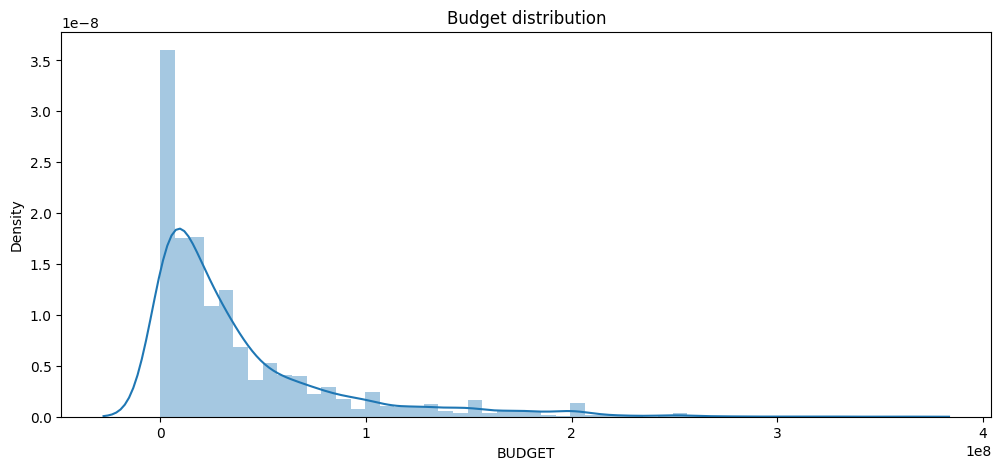

In [163]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['BUDGET'])
plt.title('Budget distribution')
plt.show()

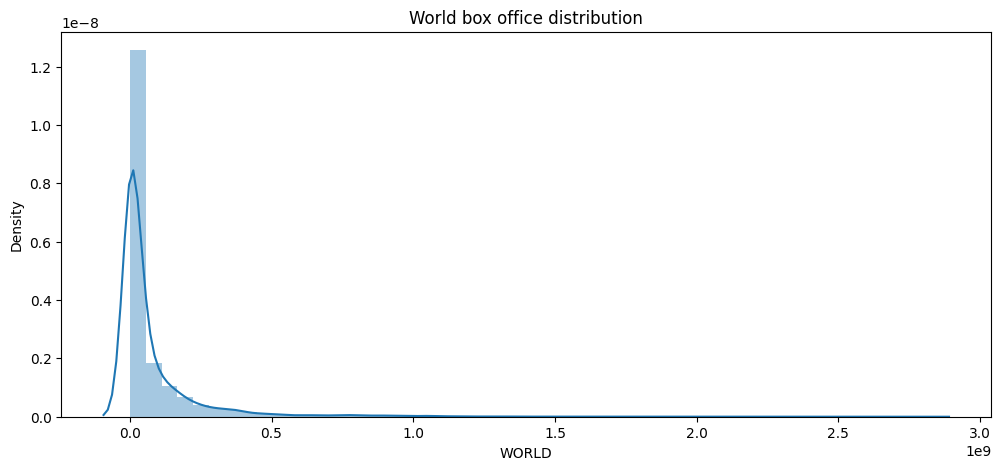

In [164]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['WORLD'])
plt.title('World box office distribution')
plt.show()

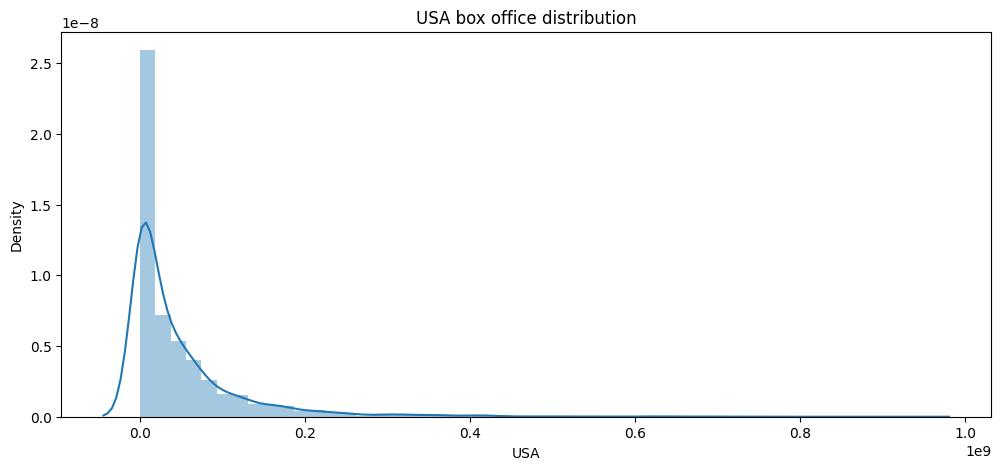

In [165]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['USA'])
plt.title('USA box office distribution')
plt.show()

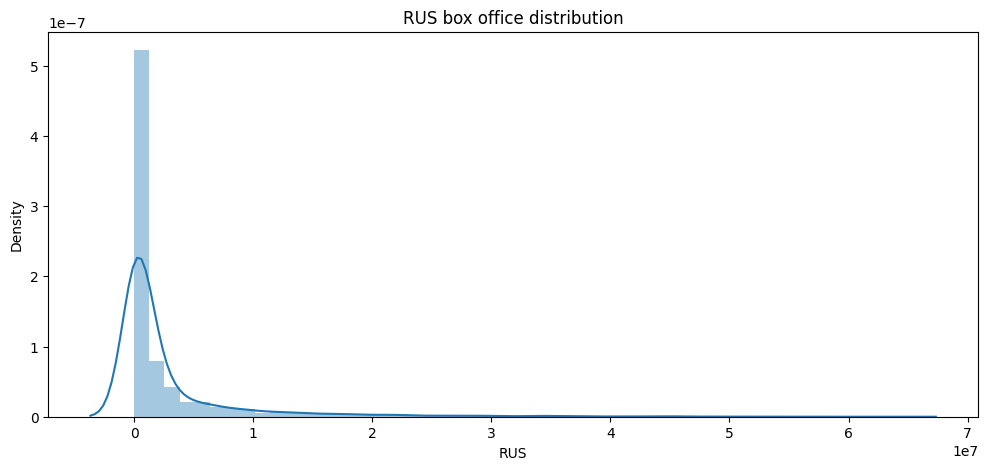

In [166]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['RUS'])
plt.title('RUS box office distribution')
plt.show()

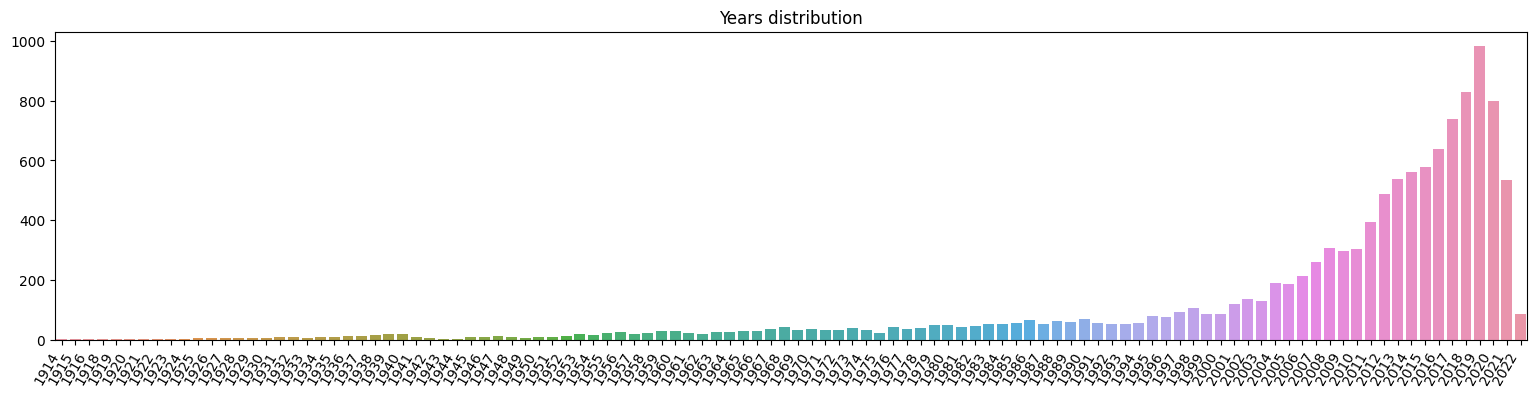

In [167]:
bar_info = df['release_year'].astype(int).value_counts()
bar_info = [(i, v) for i, v in zip(bar_info.index, bar_info.values)]
bar_info = sorted(bar_info, key=lambda x: x[0])

plt.figure(figsize=(19, 4))
chart = sns.barplot(y=[v[1] for v in bar_info], x=[v[0] for v in bar_info])
chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.title('Years distribution')
plt.show()

## Merging

In [168]:
df.shape

(11666, 15)

In [169]:
staff_df['uid'] = staff_df.index
bo_df['uid'] = bo_df.index

In [170]:
df_merged = df.merge(staff_df,
           on='uid',
            how='inner').merge(bo_df,
               on='uid',
                how='inner')

In [171]:
df_merged.shape

(10017, 28)

In [172]:
df_merged.columns

Index(['actor', 'age_access_type', 'country', 'average_rating', 'duration',
       'availability', 'type', 'name', 'release_year', 'genre', 'director',
       'target', 'subscription_only', 'uid', 'user_count_3months', 'ACTOR',
       'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR', 'OPERATOR', 'PRODUCER',
       'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD'],
      dtype='object')

In [173]:
features = ['age_access_type', 'country', 'duration',
            'type', 'name', 'release_year', 'genre', 'user_count_3months',
            'uid', 'ACTOR', 'COMPOSER', 'DESIGN',
            'DIRECTOR', 'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET',
            'MARKETING', 'RUS', 'USA', 'WORLD']

In [174]:
df_merged = df_merged[features]

In [175]:
df_merged

,age_access_type,country,duration,availability,type,name,release_year,genre,user_count_3months,subscription_only,...,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER,BUDGET,MARKETING,RUS,USA,WORLD
0,12,[usa],6420000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 5: Последний рубеж,1989,"[Sci-Fi, Action, Thriller, Adventure]",6,False,...,[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет...",27800000.0,NaN,NaN,52210049.0,52210049.0
1,16,[usa],6780000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 6: Неоткрытая страна,1991,"[Sci-Fi, Action, Thriller, Adventure]",11,False,...,[Николас Мейер],"[Уильям Хой, Рональд Руз]",[Хиро Нарита],"[Стивен-Чарльз Джаффе, Ральф Уинтер, Брук Брет...","[Джин Родденберри, Леонард Нимой, Лоуренс Конн...",30000000.0,NaN,NaN,74888996.0,96888996.0
2,18,[usa],6000000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,В поисках древнего артефакта,2019,[Horror],19,False,...,[Джаред Кон],NaN,NaN,"[Джаред Кон, Майкл Мейландер, Брайан Перера]",[Морис Хёрли],NaN,NaN,NaN,NaN,NaN
3,18,[usa],3780000,[SUBSCRIPTION],MOVIE,Прожарка Чарли Шина,2011,"[Comedy, Documentary]",1637,True,...,[Джоэл Галлен],NaN,NaN,"[Рик Остин, Марк Бёрг, Роб Кроуфорд, Джоэл Гал...","[Рэй Джеймс, Майкл Ферруччи, Крис МакГуайр, Фр...",NaN,NaN,NaN,NaN,NaN
4,18,[usa],3780000,[SUBSCRIPTION],MOVIE,Прожарка Уильяма Шэтнера,2006,[Comedy],322,True,...,[Джоэл Галлен],"[Билл ДеРонде, Наруми Инацугу]",NaN,"[Рик Остин, Роб Кроуфорд, Джоэл Галлен, Мишель...","[Майкл Ферруччи, Мэтью Харауиц, Джо Келли, Аар...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10012,0,[france],36300000,[SUBSCRIPTION],SERIAL,Эрнест и Селестина,2017,"[Family, Cartoons]",1866,True,...,"[Жюльен Шен, Жан-Кристоф Роже]",NaN,NaN,"[Дамиен Брюннер, Дидье Брюннер, Стефан Роэлант...","[Суэна Эро, Аньес Бидо, Мойра Берар, Томоко Ха...",NaN,NaN,NaN,NaN,NaN
10013,16,[ukraine],29040000,[SUBSCRIPTION],SERIAL,"Мульт ""Кухня""",2017,"[Comedy, Cartoons]",39,True,...,"[Валерия Малкова, Вячеслав Левковский, Дмитрий...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,12,[russia],12240000,[SUBSCRIPTION],SERIAL,Без памяти,2021,"[Comedy, Melodrama]",14958,True,...,[Владимир Котт],NaN,[Андрей Капранов],"[Александр Плотников, Альберт Рябышев, Андрей ...","[Константин Наумочкин, Сергей Соколов, Наталья...",NaN,NaN,NaN,NaN,NaN
10015,16,[south-korea],8400000,"[SUBSCRIPTION, AVOD]",SERIAL,Всплеск любви,2015,"[Melodrama, Fantasy]",2056,False,...,[Ким Джи-хён],NaN,NaN,NaN,[Ким Джи-хён],NaN,NaN,NaN,NaN,NaN


# df_merged eda

In [5]:
with open('item_coldstart_dataset_kp.pkl', 'rb') as f:
    df_merged = pickle.load(f)

In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10017 entries, 0 to 10016
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age_access_type     10017 non-null  object 
 1   country             10017 non-null  object 
 2   duration            10017 non-null  float64
 3   availability        9888 non-null   object 
 4   type                10017 non-null  object 
 5   name                10017 non-null  object 
 6   release_year        10017 non-null  float64
 7   genre               10017 non-null  object 
 8   user_count_3months  10017 non-null  int64  
 9   subscription_only   10017 non-null  object 
 10  uid                 10017 non-null  object 
 11  ACTOR               9816 non-null   object 
 12  COMPOSER            8710 non-null   object 
 13  DESIGN              8630 non-null   object 
 14  DIRECTOR            9875 non-null   object 
 15  EDITOR              8257 non-null   object 
 16  OPER

In [7]:
df_merged['duration'] = df_merged['duration'].astype(float)
df_merged['release_year'] = df_merged['release_year'].astype(float)

In [8]:
df_merged.isnull().sum()

age_access_type          0
country                  0
duration                 0
availability           129
type                     0
name                     0
release_year             0
genre                    0
user_count_3months       0
subscription_only        0
uid                      0
ACTOR                  201
COMPOSER              1307
DESIGN                1387
DIRECTOR               142
EDITOR                1760
OPERATOR              1384
PRODUCER              1090
WRITER                 328
BUDGET                6874
MARKETING             9768
RUS                   6592
USA                   6560
WORLD                 5031
dtype: int64

## Multivariate analysis

In [178]:
features

['age_access_type',
 'country',
 'duration',
 'availability',
 'type',
 'name',
 'release_year',
 'genre',
 'user_count_3months',
 'subscription_only',
 'uid',
 'ACTOR',
 'COMPOSER',
 'DESIGN',
 'DIRECTOR',
 'EDITOR',
 'OPERATOR',
 'PRODUCER',
 'WRITER',
 'BUDGET',
 'MARKETING',
 'RUS',
 'USA',
 'WORLD']

<AxesSubplot: >

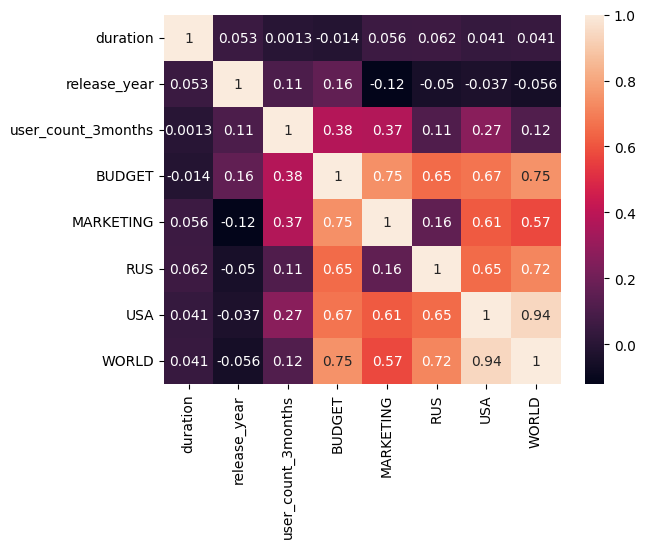

In [179]:
sns.heatmap(df_merged.corr(), annot=True)

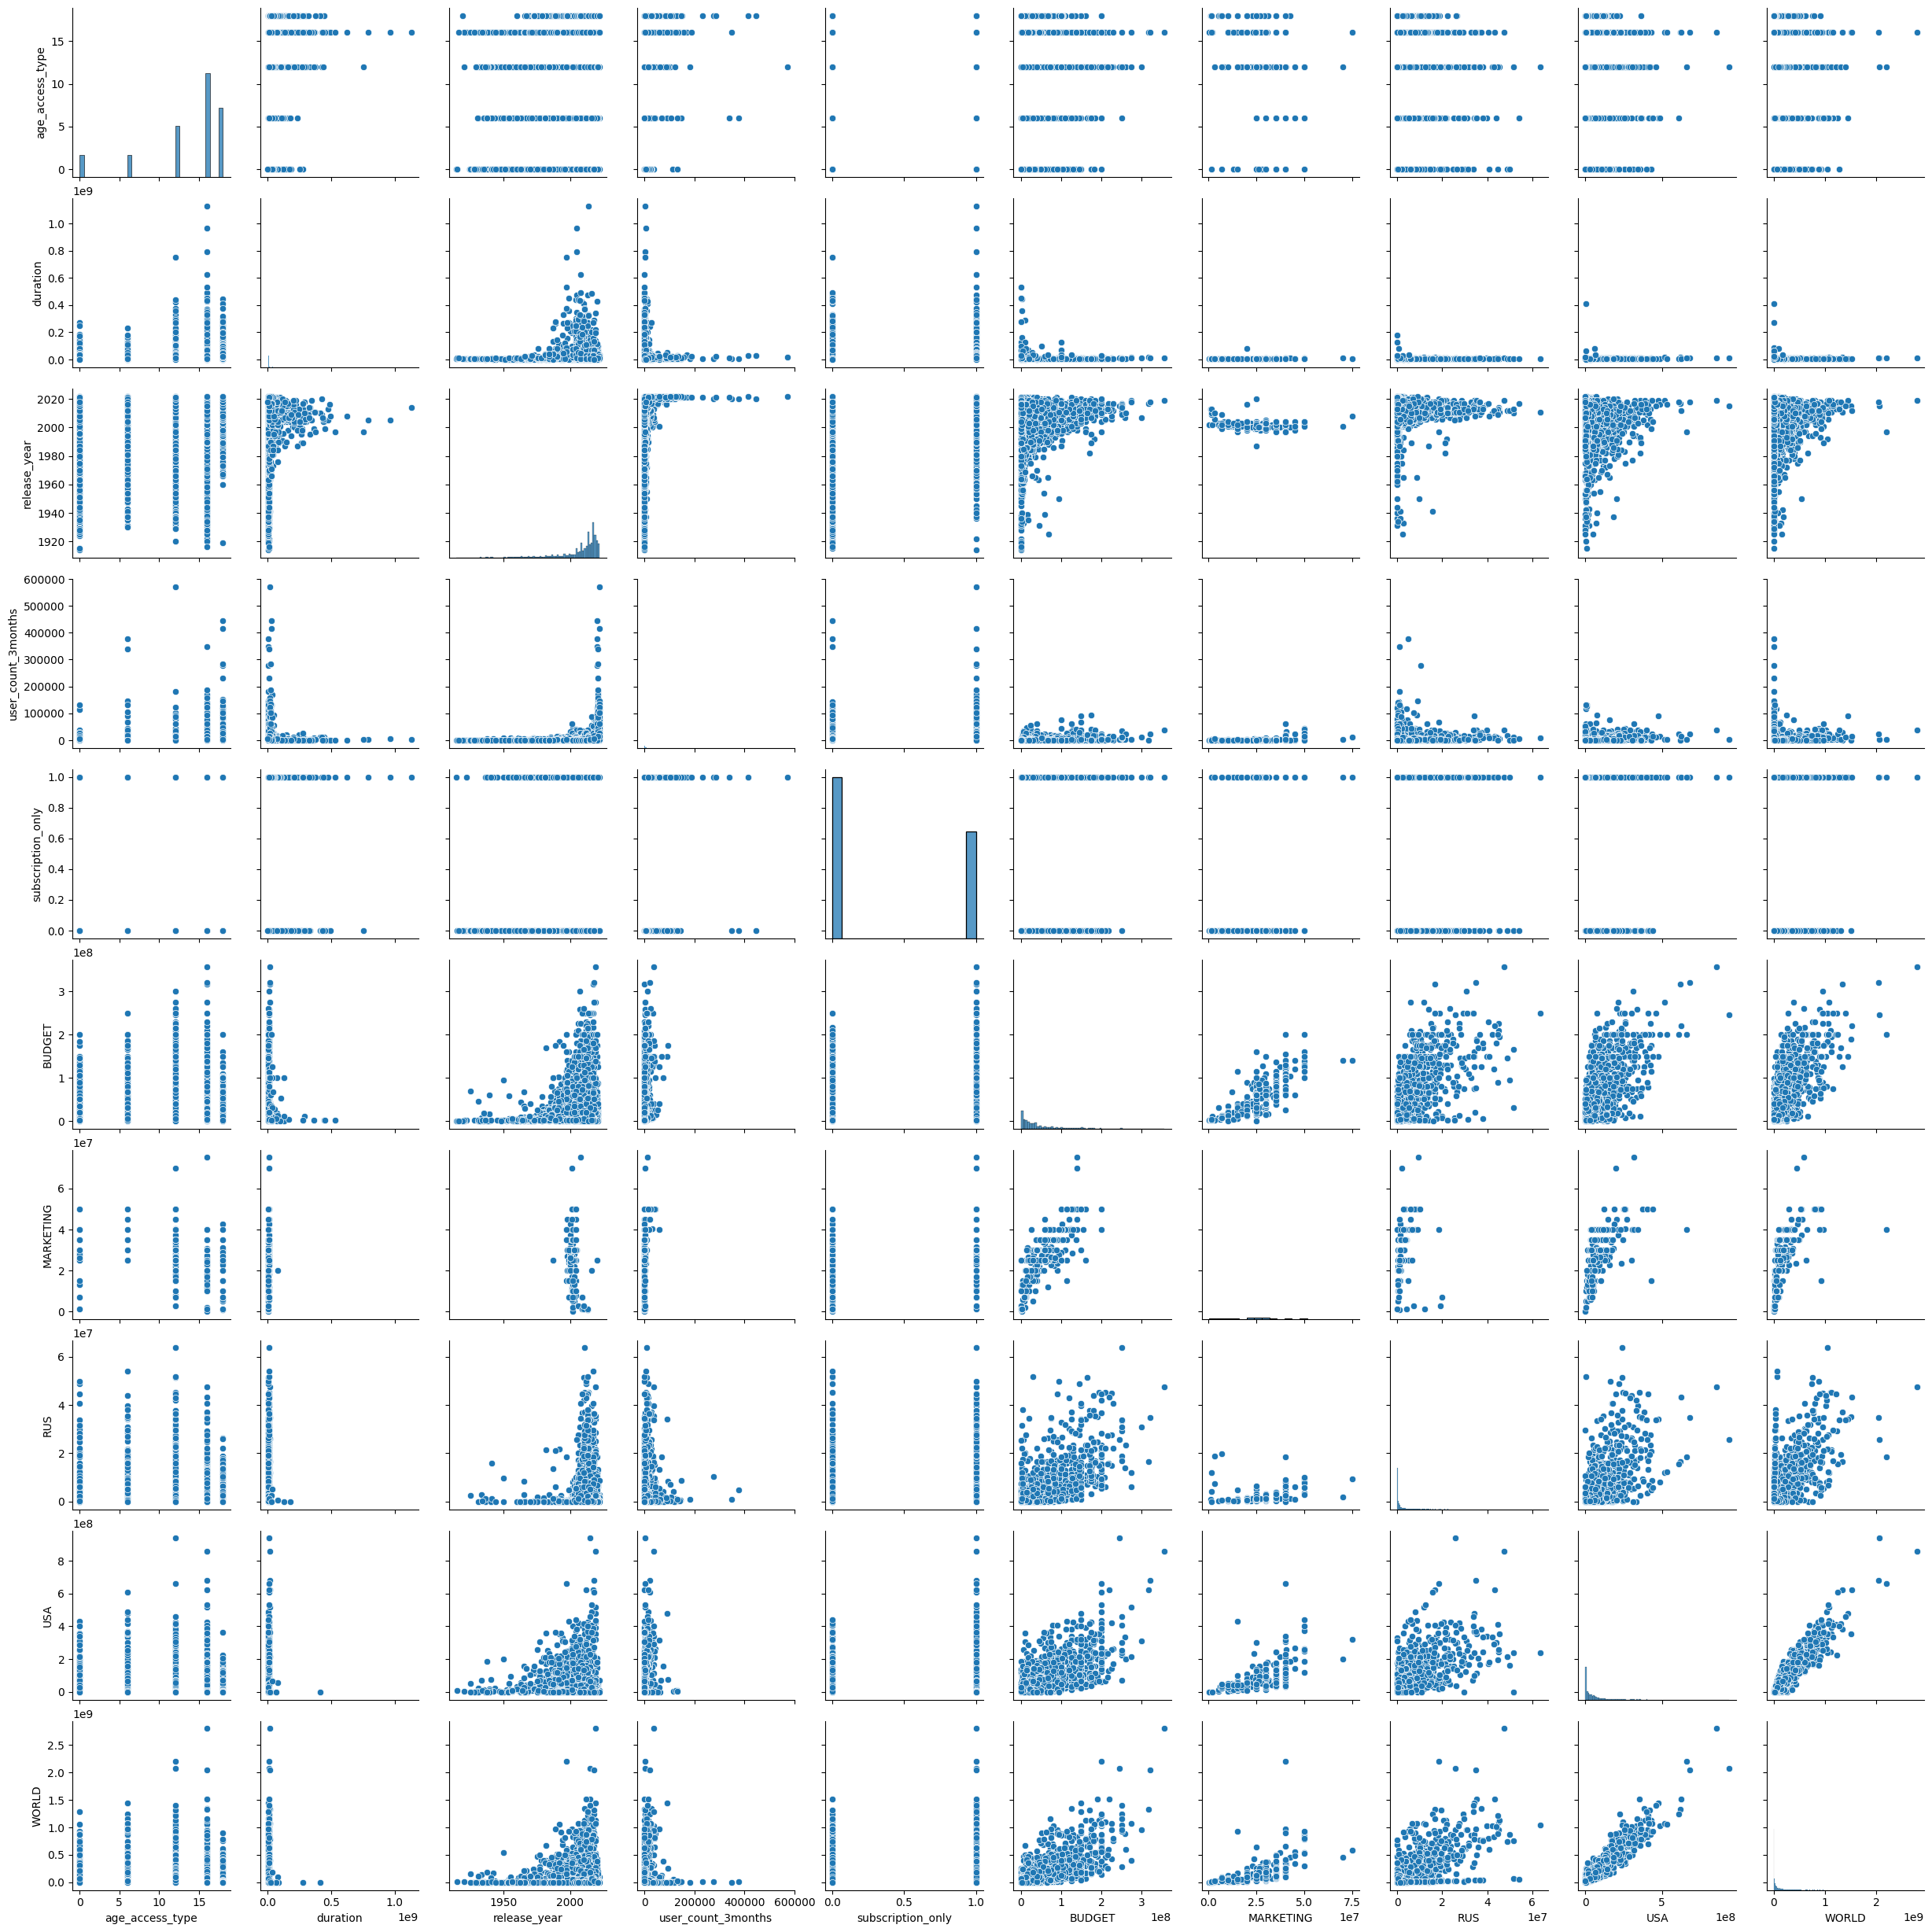

In [180]:
sns.pairplot(df_merged)
plt.show()

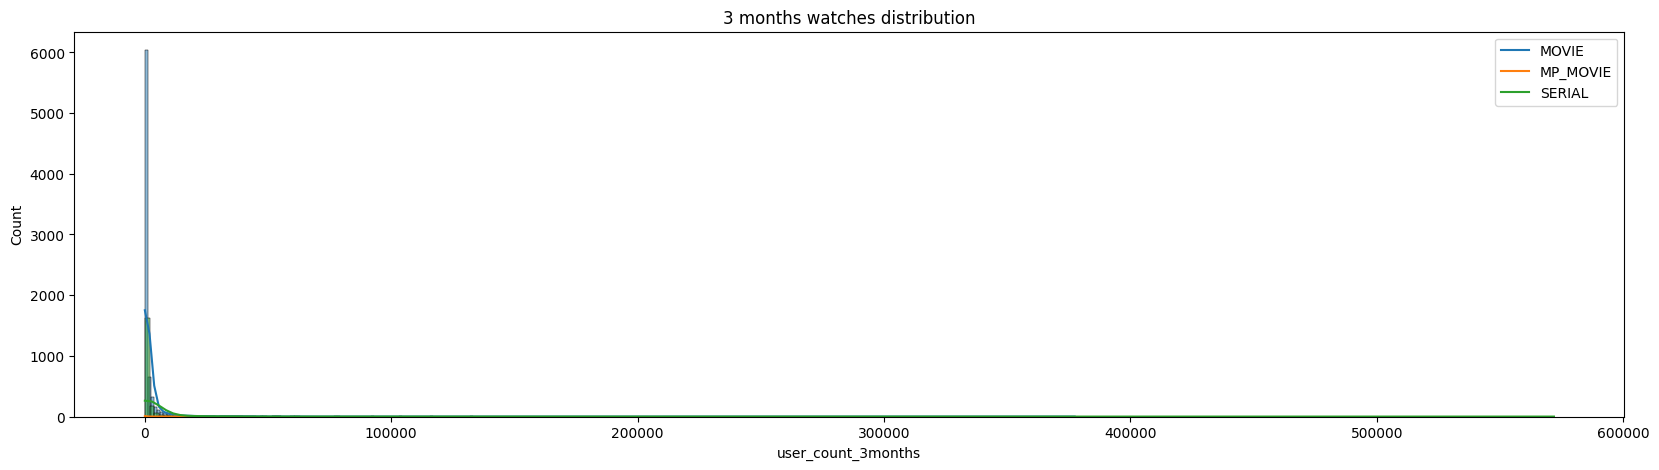

In [181]:
plt.figure(figsize=(20, 5))
for t in df_merged['type'].unique():
    sns.histplot(df_merged[df_merged['type'] == t]['user_count_3months'], bins=300, kde=True)
plt.legend(df_merged['type'].unique())
plt.title('3 months watches distribution')
plt.show()

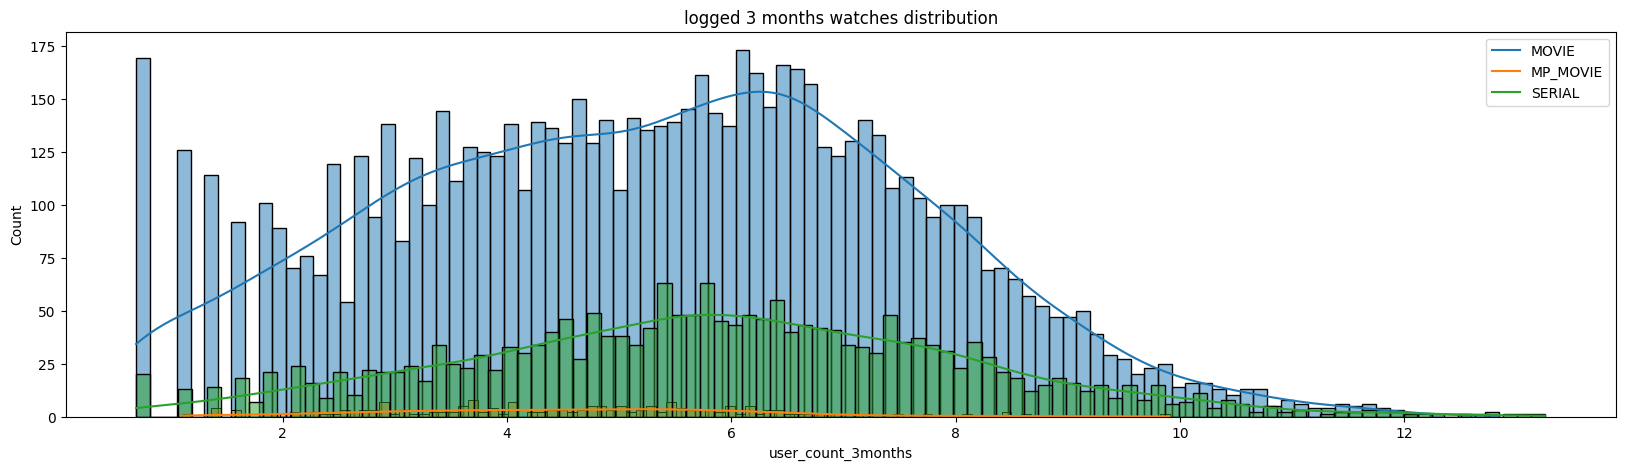

In [182]:
plt.figure(figsize=(20, 5))
for t in df_merged['type'].unique():
    sns.histplot(df_merged[df_merged['type'] == t]['user_count_3months'].apply(np.log1p), bins=100, kde=True)
plt.legend(df_merged['type'].unique())
plt.title('logged 3 months watches distribution')
plt.show()

In [183]:
df_merged

,age_access_type,country,duration,availability,type,name,release_year,genre,user_count_3months,subscription_only,...,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER,BUDGET,MARKETING,RUS,USA,WORLD
0,12,[usa],6420000.0,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 5: Последний рубеж,1989.0,"[Sci-Fi, Action, Thriller, Adventure]",6,False,...,[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет...",27800000.0,NaN,NaN,52210049.0,52210049.0
1,16,[usa],6780000.0,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 6: Неоткрытая страна,1991.0,"[Sci-Fi, Action, Thriller, Adventure]",11,False,...,[Николас Мейер],"[Уильям Хой, Рональд Руз]",[Хиро Нарита],"[Стивен-Чарльз Джаффе, Ральф Уинтер, Брук Брет...","[Джин Родденберри, Леонард Нимой, Лоуренс Конн...",30000000.0,NaN,NaN,74888996.0,96888996.0
2,18,[usa],6000000.0,"[DTO, RENT, SUBSCRIPTION]",MOVIE,В поисках древнего артефакта,2019.0,[Horror],19,False,...,[Джаред Кон],NaN,NaN,"[Джаред Кон, Майкл Мейландер, Брайан Перера]",[Морис Хёрли],NaN,NaN,NaN,NaN,NaN
3,18,[usa],3780000.0,[SUBSCRIPTION],MOVIE,Прожарка Чарли Шина,2011.0,"[Comedy, Documentary]",1637,True,...,[Джоэл Галлен],NaN,NaN,"[Рик Остин, Марк Бёрг, Роб Кроуфорд, Джоэл Гал...","[Рэй Джеймс, Майкл Ферруччи, Крис МакГуайр, Фр...",NaN,NaN,NaN,NaN,NaN
4,18,[usa],3780000.0,[SUBSCRIPTION],MOVIE,Прожарка Уильяма Шэтнера,2006.0,[Comedy],322,True,...,[Джоэл Галлен],"[Билл ДеРонде, Наруми Инацугу]",NaN,"[Рик Остин, Роб Кроуфорд, Джоэл Галлен, Мишель...","[Майкл Ферруччи, Мэтью Харауиц, Джо Келли, Аар...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10012,0,[france],36300000.0,[SUBSCRIPTION],SERIAL,Эрнест и Селестина,2017.0,"[Family, Cartoons]",1866,True,...,"[Жюльен Шен, Жан-Кристоф Роже]",NaN,NaN,"[Дамиен Брюннер, Дидье Брюннер, Стефан Роэлант...","[Суэна Эро, Аньес Бидо, Мойра Берар, Томоко Ха...",NaN,NaN,NaN,NaN,NaN
10013,16,[ukraine],29040000.0,[SUBSCRIPTION],SERIAL,"Мульт ""Кухня""",2017.0,"[Comedy, Cartoons]",39,True,...,"[Валерия Малкова, Вячеслав Левковский, Дмитрий...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,12,[russia],12240000.0,[SUBSCRIPTION],SERIAL,Без памяти,2021.0,"[Comedy, Melodrama]",14958,True,...,[Владимир Котт],NaN,[Андрей Капранов],"[Александр Плотников, Альберт Рябышев, Андрей ...","[Константин Наумочкин, Сергей Соколов, Наталья...",NaN,NaN,NaN,NaN,NaN
10015,16,[south-korea],8400000.0,"[SUBSCRIPTION, AVOD]",SERIAL,Всплеск любви,2015.0,"[Melodrama, Fantasy]",2056,False,...,[Ким Джи-хён],NaN,NaN,NaN,[Ким Джи-хён],NaN,NaN,NaN,NaN,NaN


In [184]:
with open('item_coldstart_dataset_kp.pkl', 'wb') as f:
    pickle.dump(df_merged, f)

In [127]:
!pwd

/home/jovyan/work/cold_start_models


In [ ]:
# /home/jovyan/work/cold_start_models/item_coldstart_dataset_kp.pkl